# Determine MRS slice transmission

In notebook 1 we derived a zeroth order slice mask based on the minima seen in the slice transmission of an external extended source observation. Note that "transmission" is used (wrongly) here as a synonym for the variation in absolute signal level (signal in DN/sec) along a slice. In this notebook, we try to determine a normalized transmission of each slice as a percentage fraction, based on which one could derive a detector slice mask for a declared transmission cut-off (e.g. 40%, 80%, 100%). To do this a polynomial is fitted to the data in the "plateau" part of the signal in a slice. The data in each slice are then divided by the fitted polynomial, and this is done iteratively for each slice in each row of pixels on the detector.  

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Let's look at the zeroth order slice mask derived in notebook 1, w.r.t. the MTS BB measurements.

In [1]:
import funcs
import mrsobs

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
try:plt.style.use('presentation')
except: pass
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# load objects
sliceMap_0percent   = funcs.load_obj('sliceMap_0percent')
sliceEdges_0percent = funcs.load_obj('sliceEdges_0percent')

In [4]:
# Define the ids of the individual slices
sliceid1=[111,121,110,120,109,119,108,118,107,117,106,116,105,115,104,114,103,113,102,112,101]
sliceid2=[201,210,202,211,203,212,204,213,205,214,206,215,207,216,208,217,209]
sliceid3=[316,308,315,307,314,306,313,305,312,304,311,303,310,302,309,301]
sliceid4=[412,406,411,405,410,404,409,403,408,402,407,401]

In [5]:
sliceMap,alphaMap,sci_signal,sci_signal_error = {},{},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']: 
    # Load slice mask extension of distortion map
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band] = d2cMaps['sliceMap']
    alphaMap[band] = d2cMaps['alphaMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    fringe_img_error = funcs.get_cdps(band,cdpDir,output='img_error')[0]
    fringe_img_error[np.isnan(fringe_img_error)] = 0.05
    
    # Load external extended source signal
    if band == '4C':
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
        source_signal_error,bkg_signal_error = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img_error')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
        
        sci_signal_subtrbkg_error  = np.sqrt(source_signal_error**2 + bkg_signal_error**2)
        sci_signal_divfringe_error = np.abs(sci_signal[band]) * np.sqrt((sci_signal_subtrbkg_error / (source_signal-bkg_signal))**2 + (fringe_img_error/fringe_img)**2 )
        sci_signal_error[band] = sci_signal_divfringe_error
    else:
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
        source_signal_error,bkg_signal_error = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img_error')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
        
        sci_signal_subtrbkg_error  = np.sqrt(source_signal_error**2 + bkg_signal_error**2)
        sci_signal_divfringe_error = np.abs(sci_signal[band]) * np.sqrt((sci_signal_subtrbkg_error / (source_signal-bkg_signal))**2 + (fringe_img_error/fringe_img)**2 )
        sci_signal_error[band] = sci_signal_divfringe_error

<IPython.core.display.Javascript object>


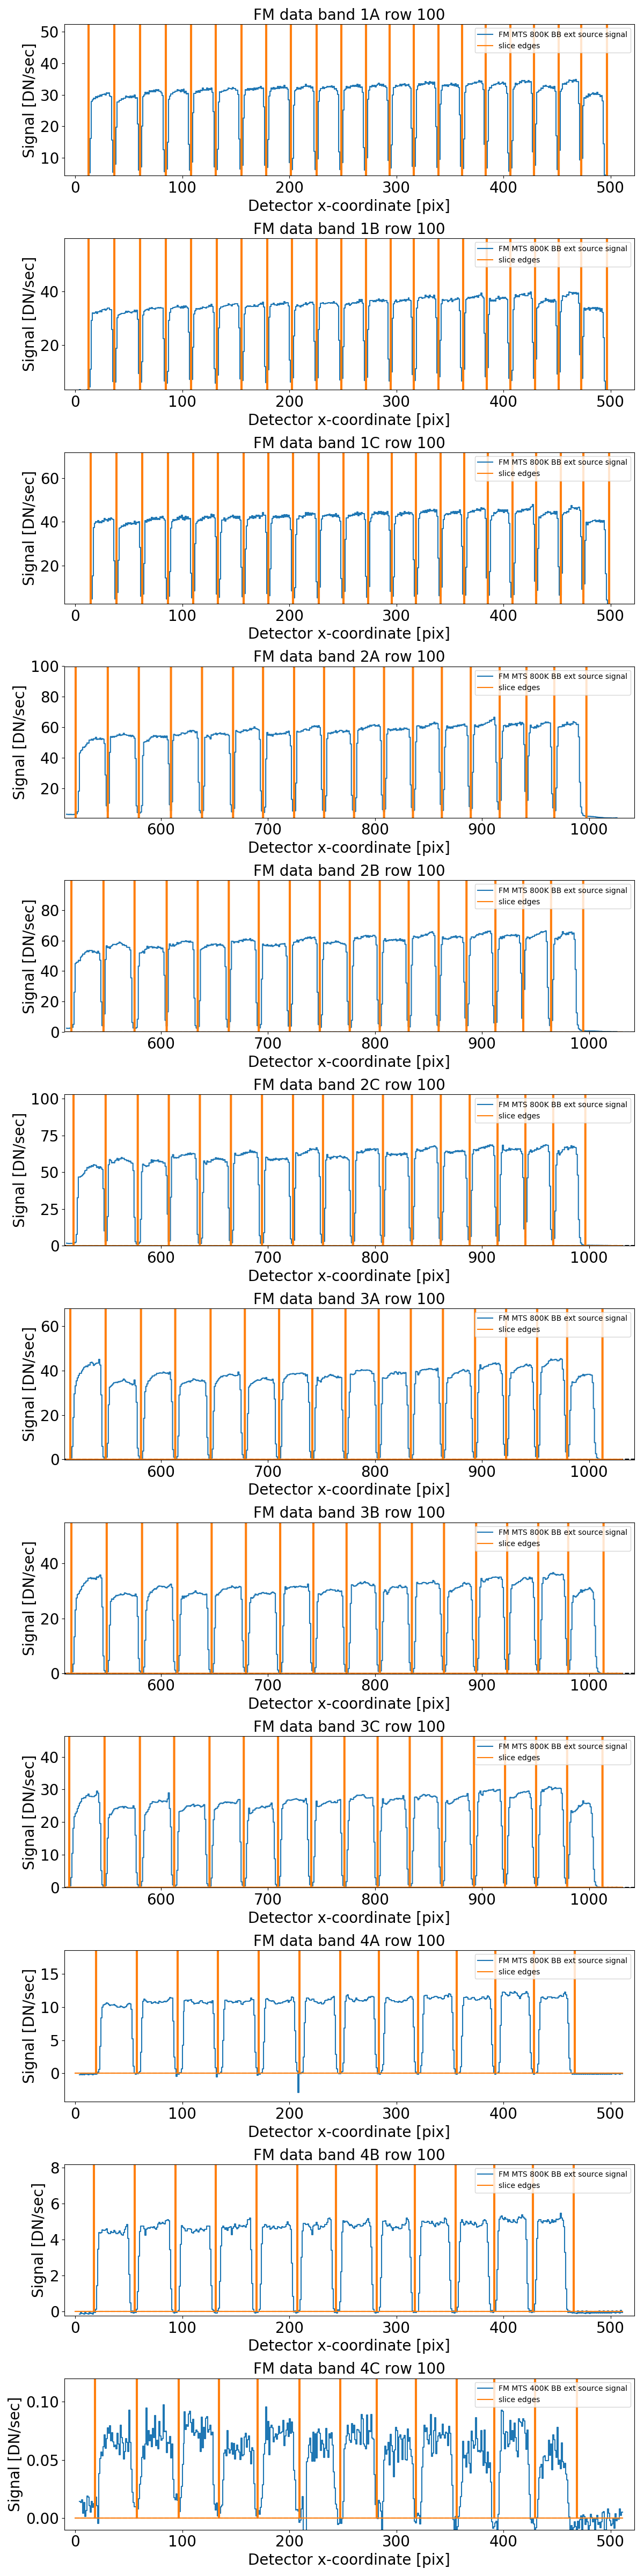

In [7]:
plt.close('all')
row = 100
fig,axs = plt.subplots(12,1,figsize=(12,48))
for plot,band in enumerate(['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']):
    axs[plot].set_title('FM data band {} row {}'.format(band,row),fontsize=20)
    if band[0] in ['1','4']:
        if band == '4C': label = 'FM MTS 400K BB ext source signal'
        else: label = 'FM MTS 800K BB ext source signal'
        axs[plot].step(np.arange(len(sci_signal[band][row,:512])),sci_signal[band][row,:512],label=label)
        axs[plot].step(np.arange(len(sliceEdges_0percent[band][row,:512])),sliceEdges_0percent[band][row,:512]*1000.,label='slice edges')
        axs[plot].hlines(0,0,512,linestyle='dashed')
        axs[plot].set_ylim(1.5*np.min(sci_signal[band][row,:512][~np.isnan(sci_signal[band][row,:512])]),1.5*np.max(sci_signal[band][row,:512][~np.isnan(sci_signal[band][row,:512])]))
        if band == '4C':
            axs[plot].set_ylim(-0.01,0.12)
        axs[plot].set_xlim(-10,522)
    elif band[0] in ['2','3']:
        axs[plot].step(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:],label='FM MTS 800K BB ext source signal')
        axs[plot].step(512+np.arange(len(sliceEdges_0percent[band][row,512:])),sliceEdges_0percent[band][row,512:]*1000.,label='slice edges')
        axs[plot].hlines(0,510,1042,linestyle='dashed')
        axs[plot].set_ylim(1.5*np.min(sci_signal[band][row,512:][~np.isnan(sci_signal[band][row,512:])]),1.5*np.max(sci_signal[band][row,512:][~np.isnan(sci_signal[band][row,512:])]))
        axs[plot].set_xlim(510,1042)
    axs[plot].set_xlabel('Detector x-coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Signal [DN/sec]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=10)
    axs[plot].tick_params(axis='both',labelsize=20)
plt.tight_layout()

The signal in the MRS slices is normalized by a polynomial fitted to the "flat" part of the signal. This process is shown below. A user-defined transmission criterion (e.g. 20%) is used to define the slice edges.

In [6]:
transm_criterion = 0.2

# Band 1A

Percent residual change 5.95%
Percent residual change 0.01%
Stopping. 5.0 percent criterion met.


<IPython.core.display.Javascript object>


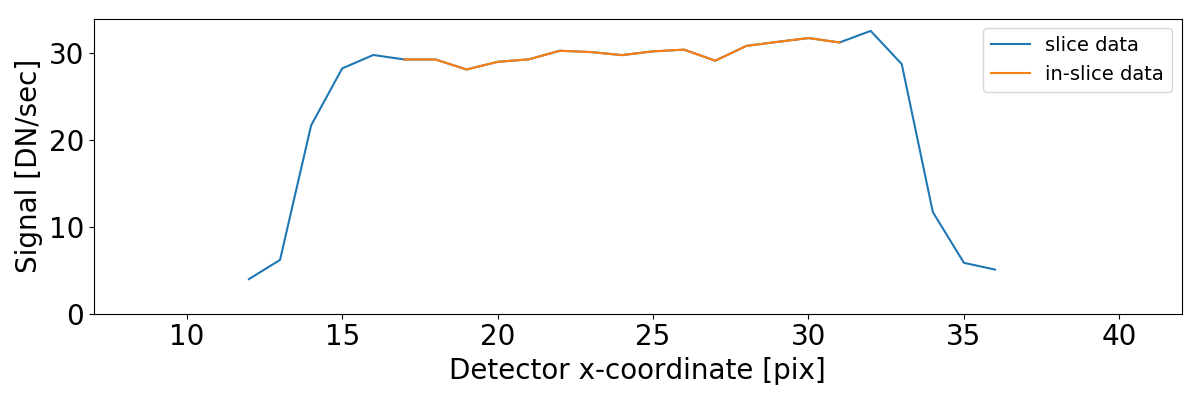

<IPython.core.display.Javascript object>


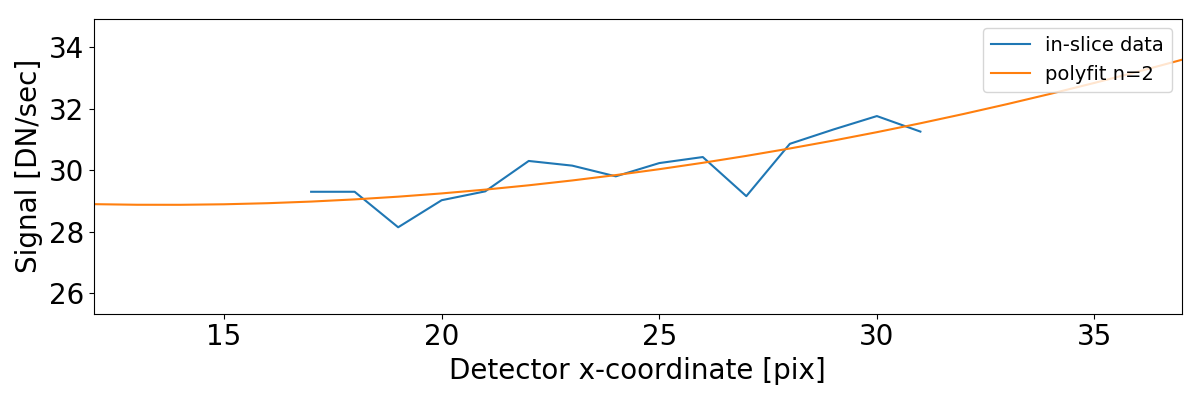

<IPython.core.display.Javascript object>


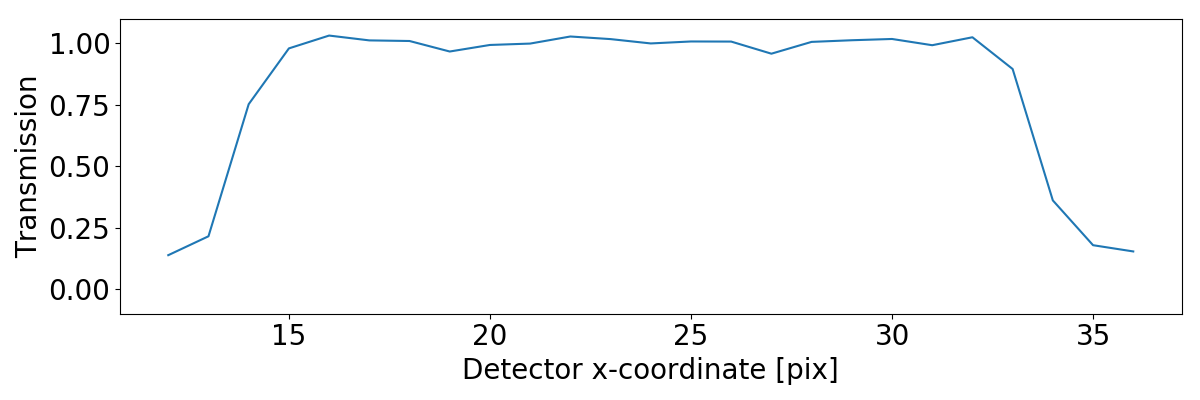

<IPython.core.display.Javascript object>


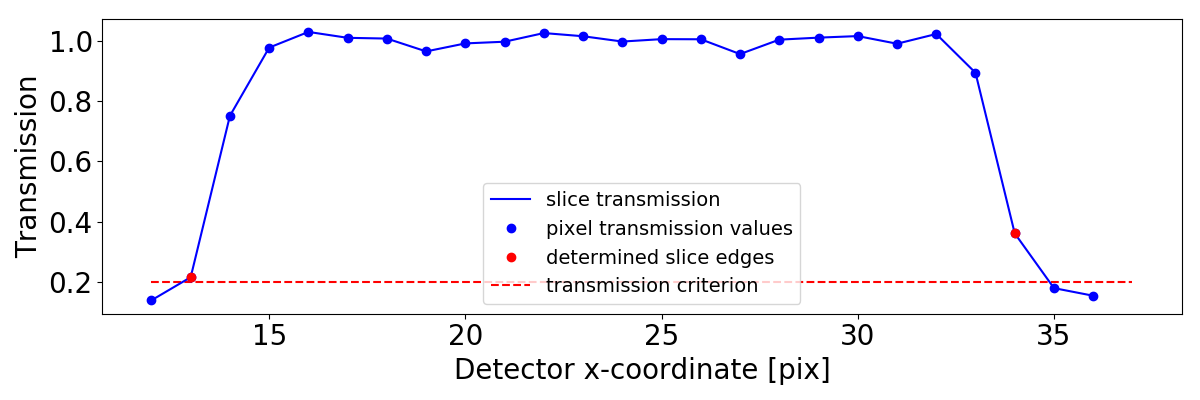

In [7]:
# Test single row, single slice - band 1A
band   = '1A'
row    = 1
islice = 111
margin = 5 # pix
flag   = 0

signal = pd.DataFrame(sci_signal[band])
interp_signal = signal.interpolate(method='nearest').as_matrix()

signal_error = pd.DataFrame(sci_signal_error[band])
interp_signal_error = signal_error.interpolate(method='nearest').as_matrix()

lower = np.where(sliceMap_0percent[band][row,:] == islice)[0][0]
upper = np.where(sliceMap_0percent[band][row,:] == islice)[0][-1]+2

xdata = np.arange(1032)[lower+margin:upper-margin]
ydata = interp_signal[row,lower+margin:upper-margin]
sigma = interp_signal_error[row,lower+margin:upper-margin]

n_poly   = 1
residual_change = 100.
residual_changes = [residual_change]
stop_criterion = 5.
counter = 0
while residual_change > stop_criterion:
    counter += 1
    popt_1     = np.polyfit(xdata,ydata,n_poly,w=1/sigma)
    poly_1     = np.poly1d(popt_1)
    residual_1 = (ydata-poly_1(xdata))**2

    popt_2     = np.polyfit(xdata,ydata,n_poly+1,w=1/sigma)
    poly_2     = np.poly1d(popt_2)
    residual_2 = (ydata-poly_2(xdata))**2
    
    residual_change = np.abs((residual_2.sum()-residual_1.sum())/residual_1.sum())*100.
    residual_changes.append(residual_change)
    print 'Percent residual change {}%'.format(round(residual_change,2))
    
    n_poly+= 1
    
    if residual_changes[counter]>residual_changes[counter-1]:
        print 'Stopping. Residuals are getting larger.'
        print 'Percent residual change {}%'.format(round(residual_changes[counter-1],2))
        flag = 1
        break
    
    if n_poly == 5:
        # stop while loop
        print 'Stopping. Polynnomial order too high.'
        break
    
    if residual_change<=stop_criterion:
        print 'Stopping. {} percent criterion met.'.format(stop_criterion)

if n_poly == 2:
    # first iteration gives good enough fit
    n_polynomial   = 1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1
else:
    # n+1 iteration gives best fit
    n_polynomial   = n_poly-1
    popt     = popt_2
    poly     = poly_2
    residual = residual_2
if flag == 1:
    n_polynomial   = n_poly-1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1

plt.figure(figsize=(12,4))
plt.plot(np.arange(1032)[lower:upper],interp_signal[row,lower:upper],label='slice data')
plt.plot(xdata,ydata,label='in-slice data')
# plt.plot(np.arange(len(np.arange(1032)[512:])),poly(np.arange(len(np.arange(1032)[512:]))),label='polyfit n={}'.format(n_poly))
plt.xlim(lower-margin,upper+margin)
plt.ylim(0.)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(xdata,ydata,label='in-slice data')
plt.plot(np.arange(len(np.arange(1032)[512:])),poly(np.arange(len(np.arange(1032)[512:]))),label='polyfit n={}'.format(n_polynomial))
plt.xlim(lower,upper)
plt.ylim(0.9*np.min(ydata[~np.isnan(ydata)]),1.1*np.max(ydata[~np.isnan(ydata)]))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(np.arange(1032)[lower:upper],interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] ))
plt.ylim(-0.1,1.1)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Transmission')
plt.tight_layout()

transmission = interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] )

min_idx = np.where(transmission>transm_criterion)[0][0]
max_idx = np.where(transmission>transm_criterion)[0][-1]

plt.figure(figsize=(12,4))
plt.plot(np.arange(1032)[lower:upper],transmission,'b',label='slice transmission')
plt.plot(np.arange(1032)[lower:upper],transmission,'bo',label='pixel transmission values')
plt.plot(lower+min_idx,transmission[min_idx],'ro',label='determined slice edges')
plt.plot(lower+max_idx,transmission[max_idx],'ro')
plt.hlines(transm_criterion,lower,upper,'r',linestyle='dashed',label='transmission criterion')
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Transmission')
plt.legend(loc='lower center')
plt.tight_layout()

The above process is repeated for all detector rows. Let's look at the resulting array of positions for the slice left edge. In order to reduce the noise in edge-position determination, a fourth order polynomial is fitted to all the positions. The polynomial values are then rounded to the nearest integer, to adhere to the pixellated nature of the MRS detector.

In [ ]:
# Test all slices, all rows - band 1A
band   = '1A'
margin = 5 # pix
new_sliceMap = np.zeros((1024,1032))
transm_img = np.zeros((1024,1032))

signal = pd.DataFrame(sci_signal[band])
interp_signal = signal.interpolate(method='nearest').as_matrix()

signal_error = pd.DataFrame(sci_signal_error[band])
interp_signal_error = signal_error.interpolate(method='nearest').as_matrix()
for islice in sliceid1:
    print 'Slice {}'.format(islice)
    for row in range(1,1023):
        try:
            lower = np.where(sliceMap_0percent[band][row,:] == islice)[0][0]
            upper = np.where(sliceMap_0percent[band][row,:] == islice)[0][-1]+2

            xdata = np.arange(1032)[lower+margin:upper-margin]
            ydata = interp_signal[row,lower+margin:upper-margin]
            sigma = interp_signal_error[row,lower+margin:upper-margin]

            n_poly   = 1
            residual_change = 100.
            residual_changes = [residual_change]
            stop_criterion = 5.
            counter = 0
            while residual_change > stop_criterion:
                counter += 1
                popt_1     = np.polyfit(xdata,ydata,n_poly,w=1/sigma)
                poly_1     = np.poly1d(popt_1)
                residual_1 = (ydata-poly_1(xdata))**2

                popt_2     = np.polyfit(xdata,ydata,n_poly+1,w=1/sigma)
                poly_2     = np.poly1d(popt_2)
                residual_2 = (ydata-poly_2(xdata))**2

                residual_change = np.abs((residual_2.sum()-residual_1.sum())/residual_1.sum())*100.
                residual_changes.append(residual_change)

                n_poly+= 1

                if residual_changes[counter]>residual_changes[counter-1]:
                    flag = 1
                    break

                if n_poly == 5:
                    break

            if n_poly == 2:
                # first iteration gives good enough fit
                n_polynomial   = 1
                popt     = popt_1
                poly     = poly_1
                residual = residual_1
            else:
                # n+1 iteration gives best fit
                n_polynomial   = n_poly-1
                popt     = popt_2
                poly     = poly_2
                residual = residual_2
            if flag == 1:
                n_polynomial   = n_poly-1
                popt     = popt_1
                poly     = poly_1
                residual = residual_1

            transmission = sci_signal[band][row,lower:upper]/poly(np.arange(1032)[lower:upper] )
            transm_img[row,lower:upper] = transmission

            min_idx = np.where(transmission>transm_criterion)[0][0]
            max_idx = np.where(transmission>transm_criterion)[0][-1]

            new_sliceMap[row,lower+min_idx+1:lower+max_idx] = islice
        except:
            print row
            break
new_sliceMap[0,:] = new_sliceMap[1,:]
new_sliceMap[1023,:] = new_sliceMap[1022,:]

<IPython.core.display.Javascript object>


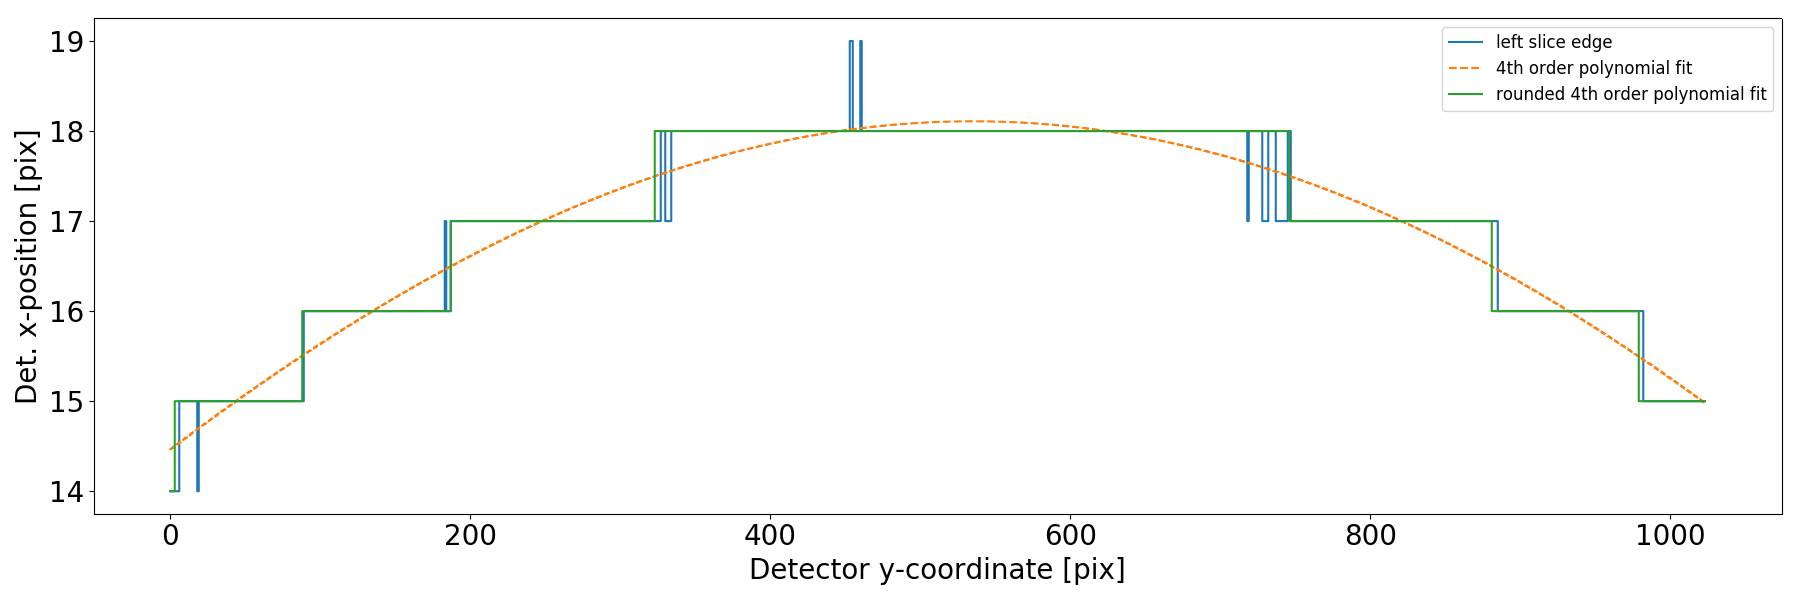

In [9]:
new_sliceMap_poly = np.zeros((1024,1032))
edge_pixels_left,edge_pixels_right = {},{}
for islice in sliceid1:
    edge_pixels_left[str(islice)],edge_pixels_right[str(islice)] = np.zeros(1024),np.zeros(1024)
    for row in range(1024):
        edge_pixels_left[str(islice)][row]  = np.where(new_sliceMap[row,:] == islice)[0][0]
        edge_pixels_right[str(islice)][row] = np.where(new_sliceMap[row,:] == islice)[0][-1]
    
    # shifts of more than two pixels are rejected
    for row in range(1,1024):
        if (np.abs(edge_pixels_left[str(islice)][row]-edge_pixels_left[str(islice)][row-1]) ==2):
            edge_pixels_left[str(islice)][row-1] = np.nan
            
        if (np.abs(edge_pixels_right[str(islice)][row]-edge_pixels_right[str(islice)][row-1]) ==2):
            edge_pixels_right[str(islice)][row-1] = np.nan
        
    sel_left  = ~np.isnan(edge_pixels_left[str(islice)])
    popt_left = np.polyfit(np.arange(1024)[sel_left],edge_pixels_left[str(islice)][sel_left],4)
    poly_left = np.poly1d(popt_left)
    
    if islice == 111:
        plt.figure(figsize=(18,6))
        plt.step(np.arange(1024)[sel_left],edge_pixels_left[str(islice)][sel_left],label='left slice edge')
        plt.step(np.arange(1024),poly_left(np.arange(1024)),linestyle='dashed',label='4th order polynomial fit')
        plt.step(np.arange(1024),np.around(poly_left(np.arange(1024))),label='rounded 4th order polynomial fit')
        plt.xlabel('Detector y-coordinate [pix]')
        plt.ylabel('Det. x-position [pix]')
        plt.legend(loc='upper right',fontsize=12)
        plt.tight_layout()
    
    sel_right  = ~np.isnan(edge_pixels_right[str(islice)])
    popt_right = np.polyfit(np.arange(1024)[sel_right],edge_pixels_right[str(islice)][sel_right],4)
    poly_right = np.poly1d(popt_right)
    
    for row in range(1024):
        assert np.around(poly_left(np.arange(1024))[row])<=np.around(poly_right(np.arange(1024))[row])+2, 'Something went wrong in the polynomial fitting'
        new_sliceMap_poly[row,np.around(poly_left(np.arange(1024))[row]):np.around(poly_right(np.arange(1024))[row])+2] = islice

By performing the same polynomial fitting for the right edge pixel positions, the slice is finally defined. All pixels between the left and right edge of a slice are given a unique slice number. Below we show the resulting slice map before and after the polynomial fitting (note the noise in the non-fitted slice map). Additionally the slice map is overplotted on the MTS data to verify the map's validity.

<IPython.core.display.Javascript object>


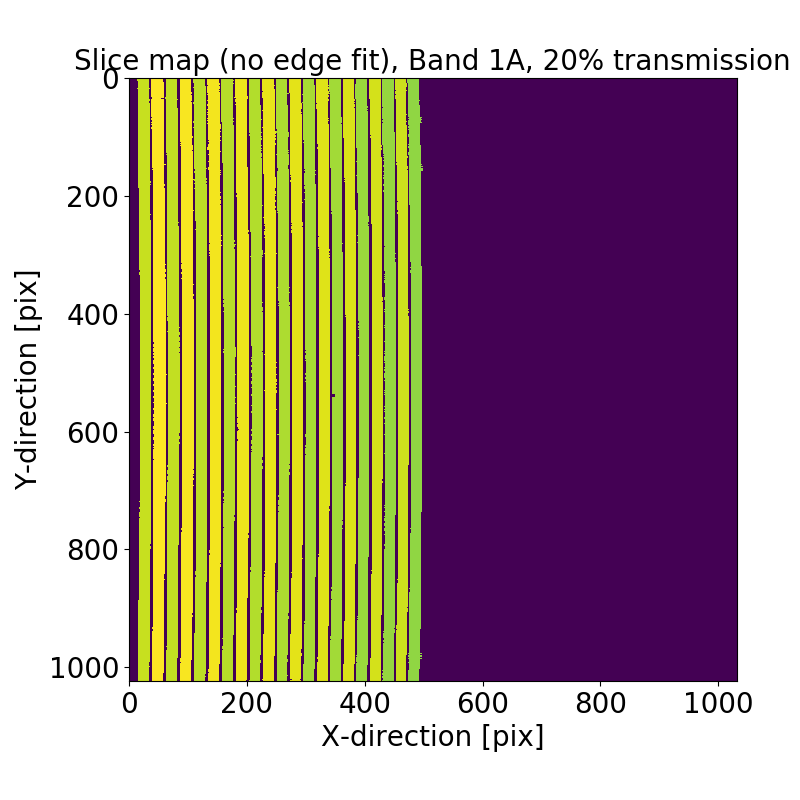

<IPython.core.display.Javascript object>


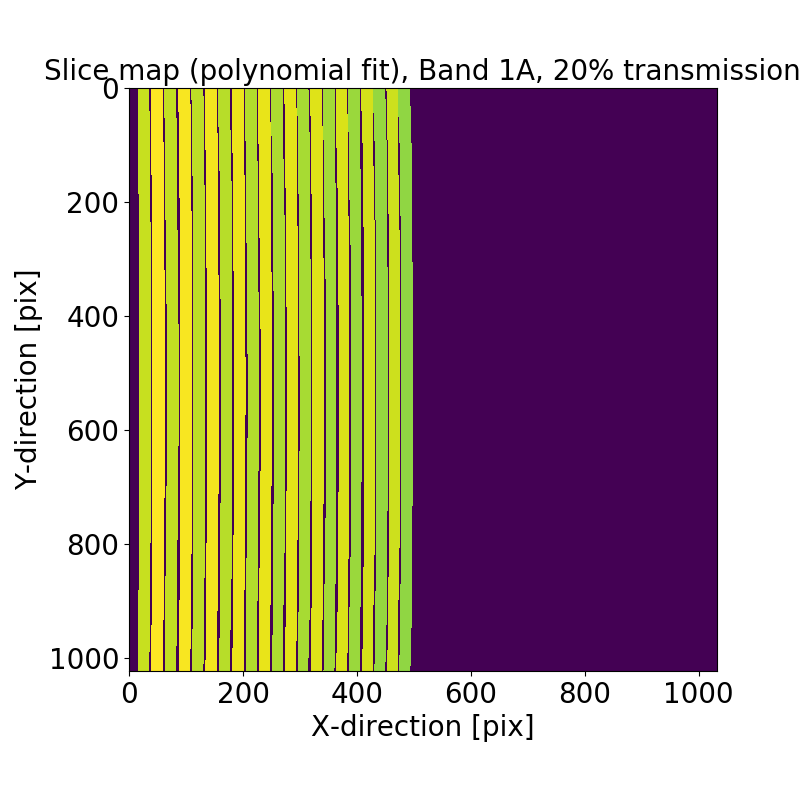

<IPython.core.display.Javascript object>


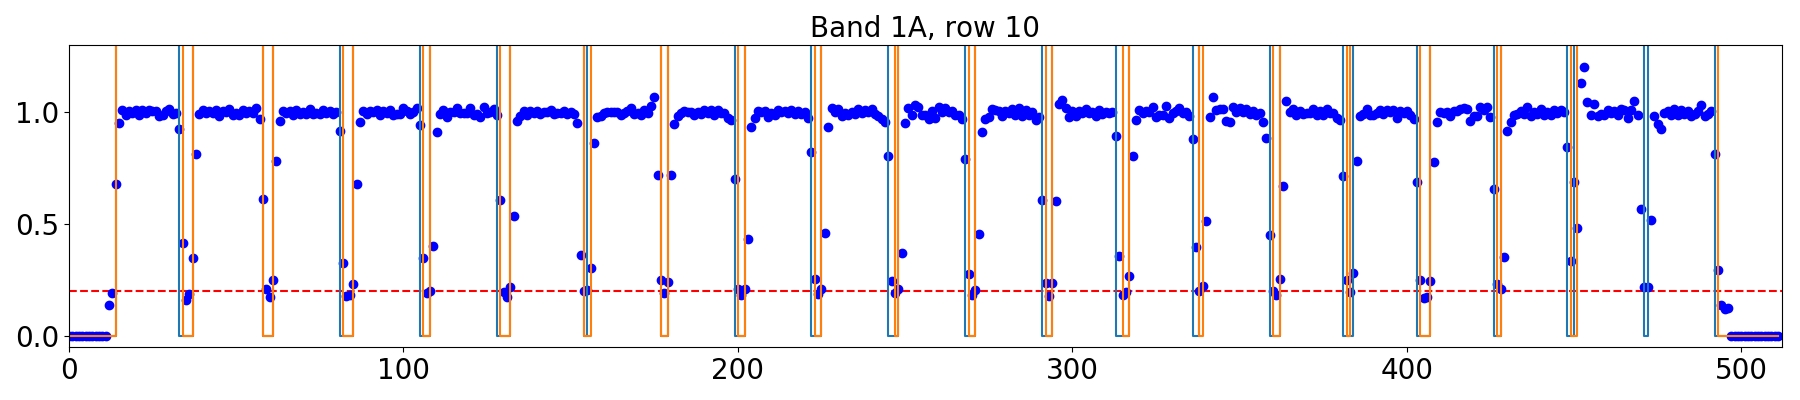

In [11]:
plt.figure(figsize=(8,8))
plt.title('Slice map (no edge fit), Band 1A, 20% transmission')
plt.imshow(new_sliceMap)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

plt.figure(figsize=(8,8))
plt.title('Slice map (polynomial fit), Band 1A, 20% transmission')
plt.imshow(new_sliceMap_poly)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

row = 10
plt.figure(figsize=(18,4))
plt.title('Band 1A, row {}'.format(row))
plt.plot(np.arange(len(transm_img[row,:512])),transm_img[row,:512],'bo')
plt.step(np.arange(len(new_sliceMap[row,:512])),new_sliceMap[row,:512])
plt.step(np.arange(len(new_sliceMap_poly[row,:512])),new_sliceMap_poly[row,:512])
plt.hlines(transm_criterion,0,512,'r',linestyle='dashed')
plt.ylim(-0.05,1.3)
plt.xlim(0,512)
plt.tight_layout()

Let us look at another normalization example, in band 3A.

Percent residual change 79.96%
Percent residual change 0.72%
Stopping. 5.0 percent criterion met.


<IPython.core.display.Javascript object>


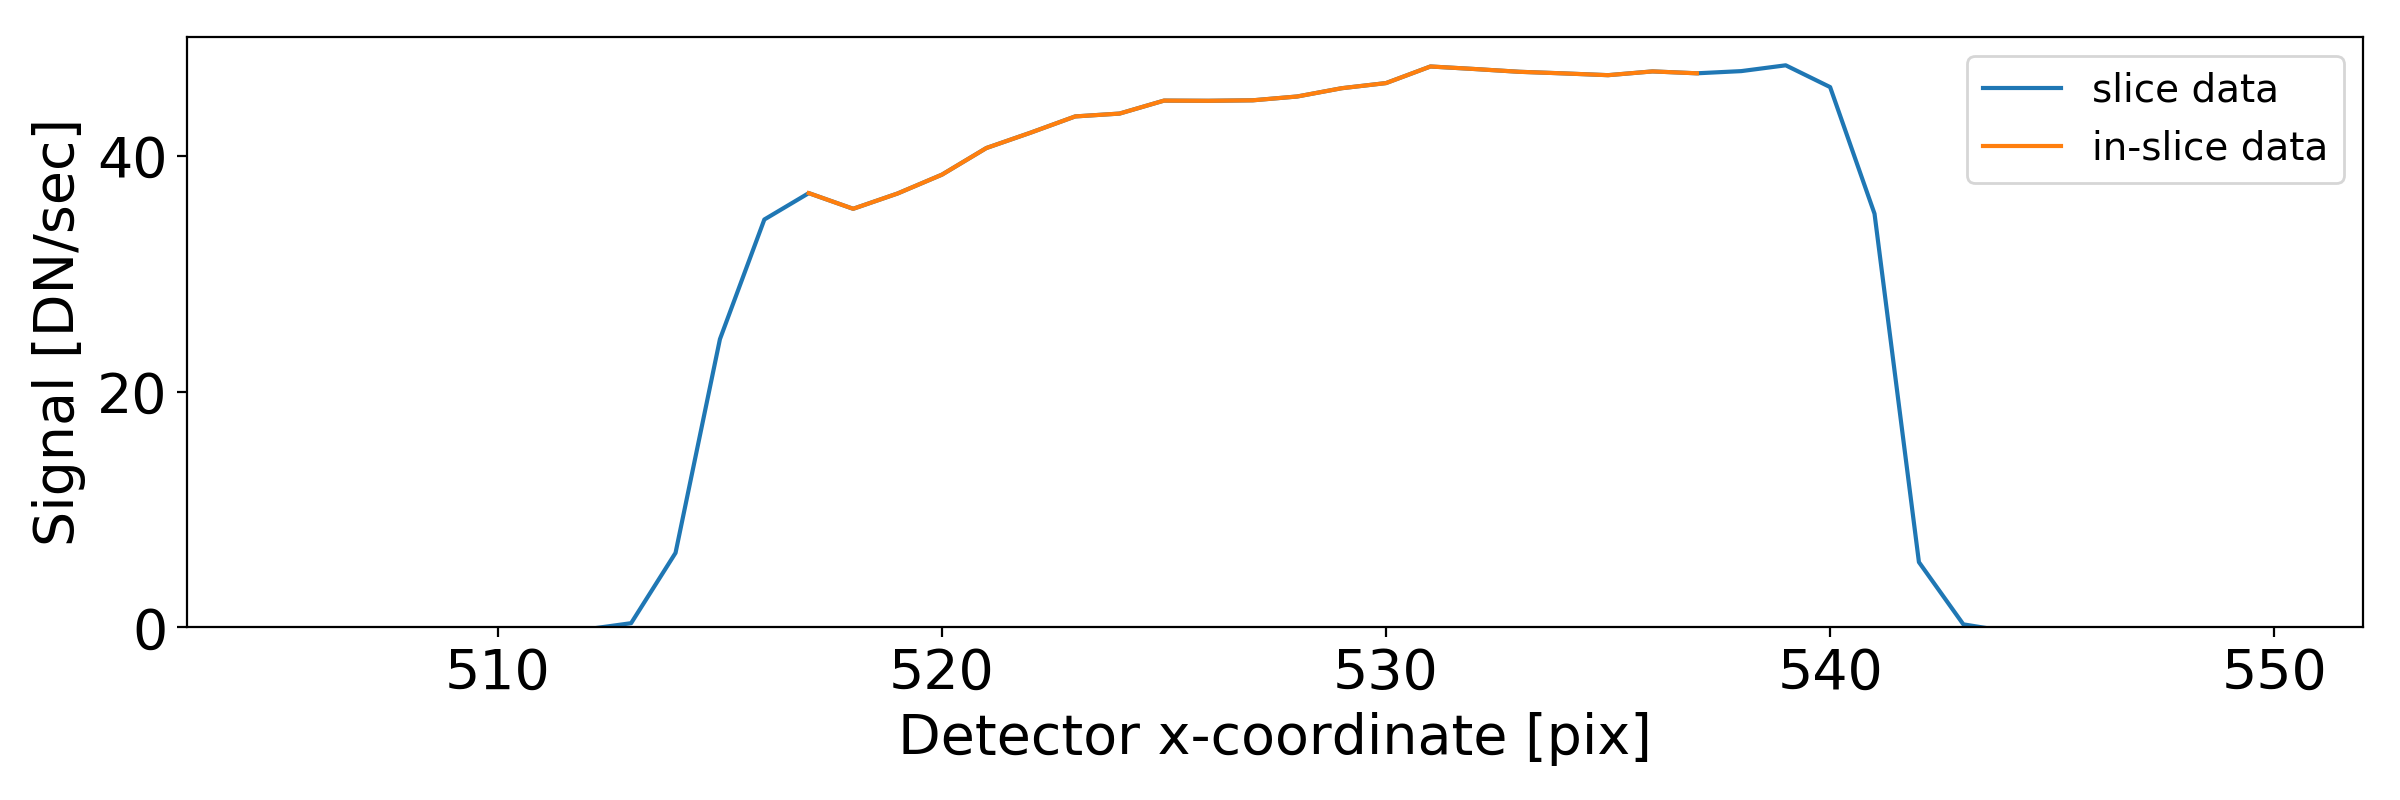

<IPython.core.display.Javascript object>


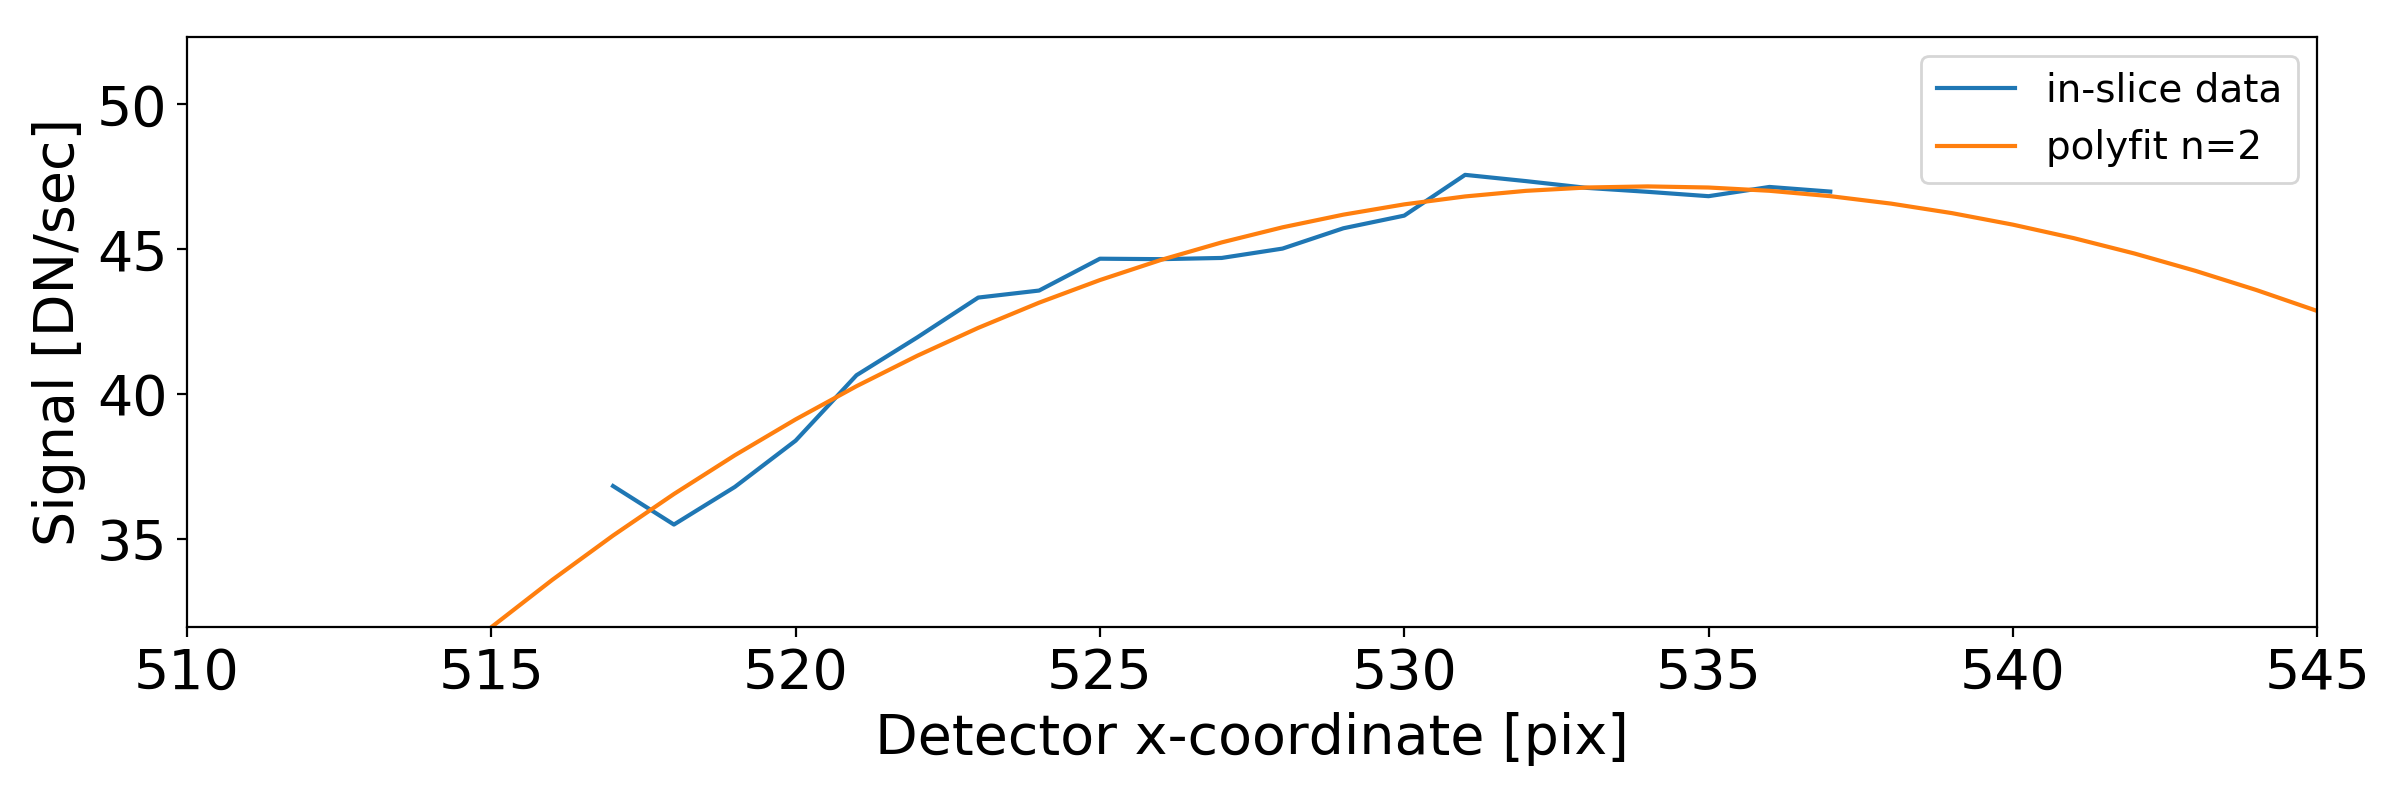

<IPython.core.display.Javascript object>


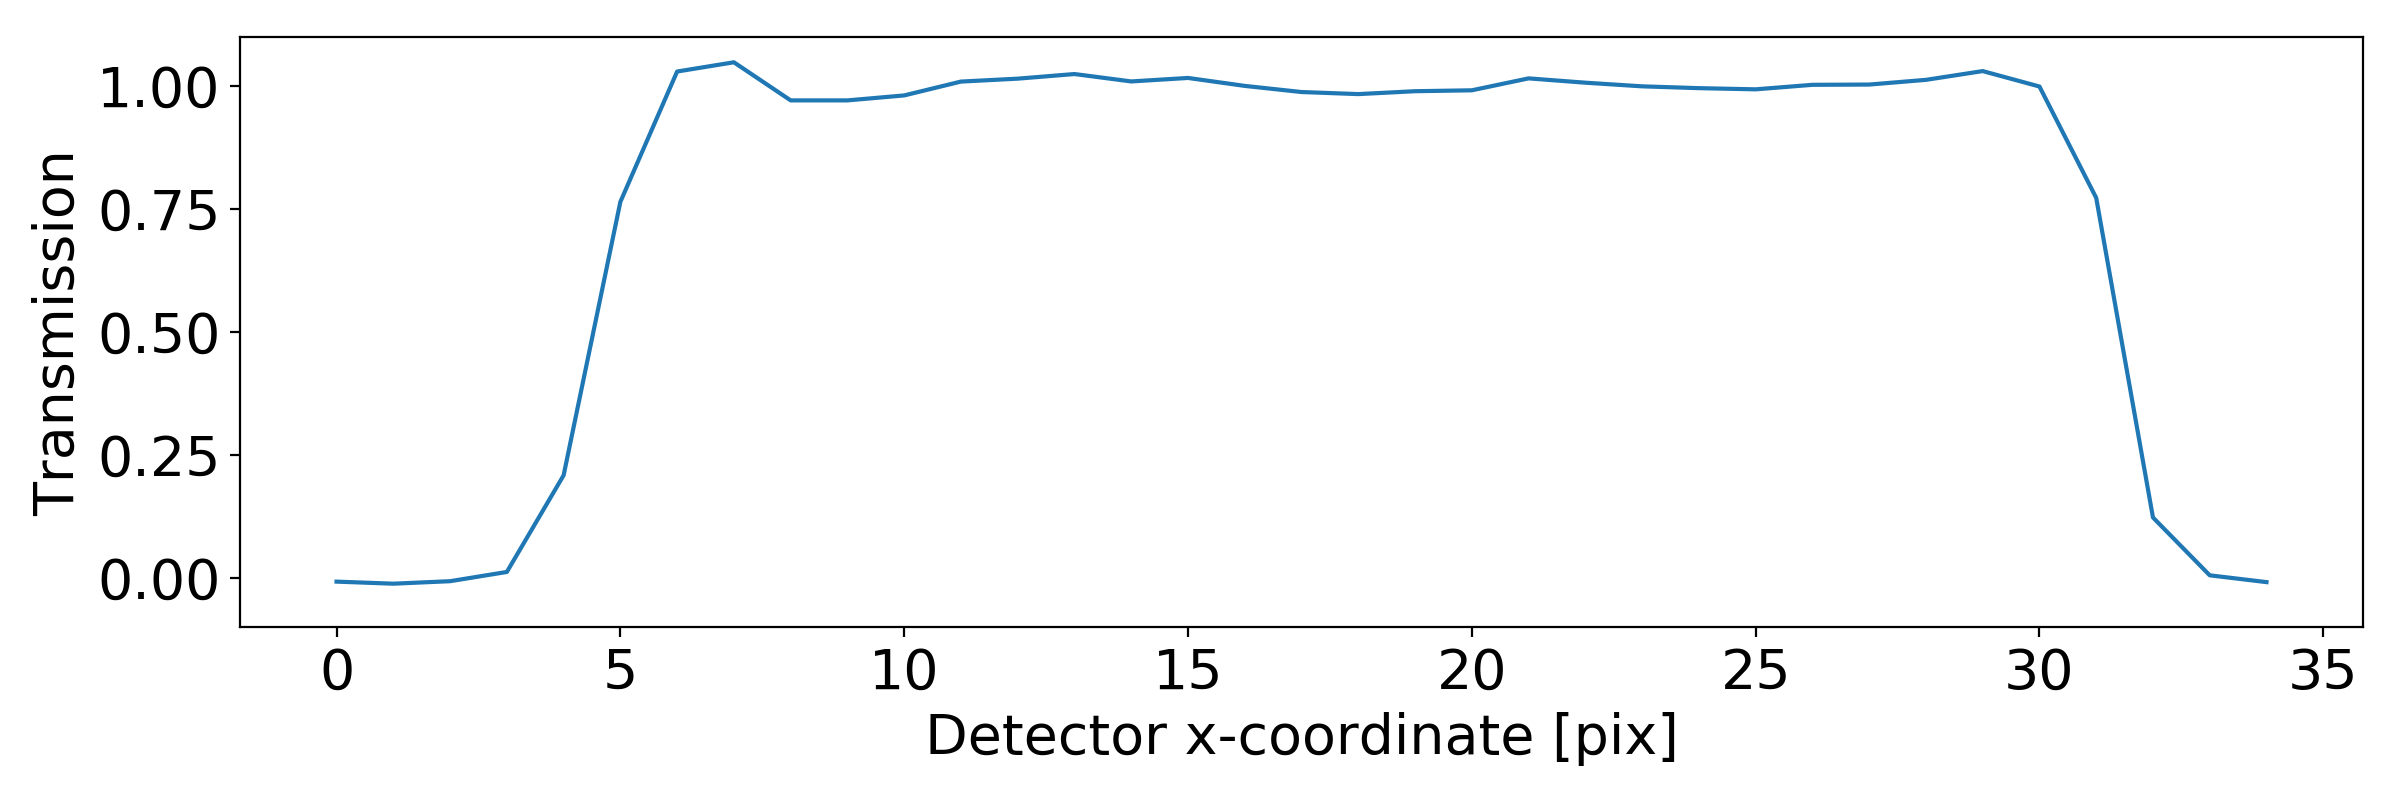

<IPython.core.display.Javascript object>


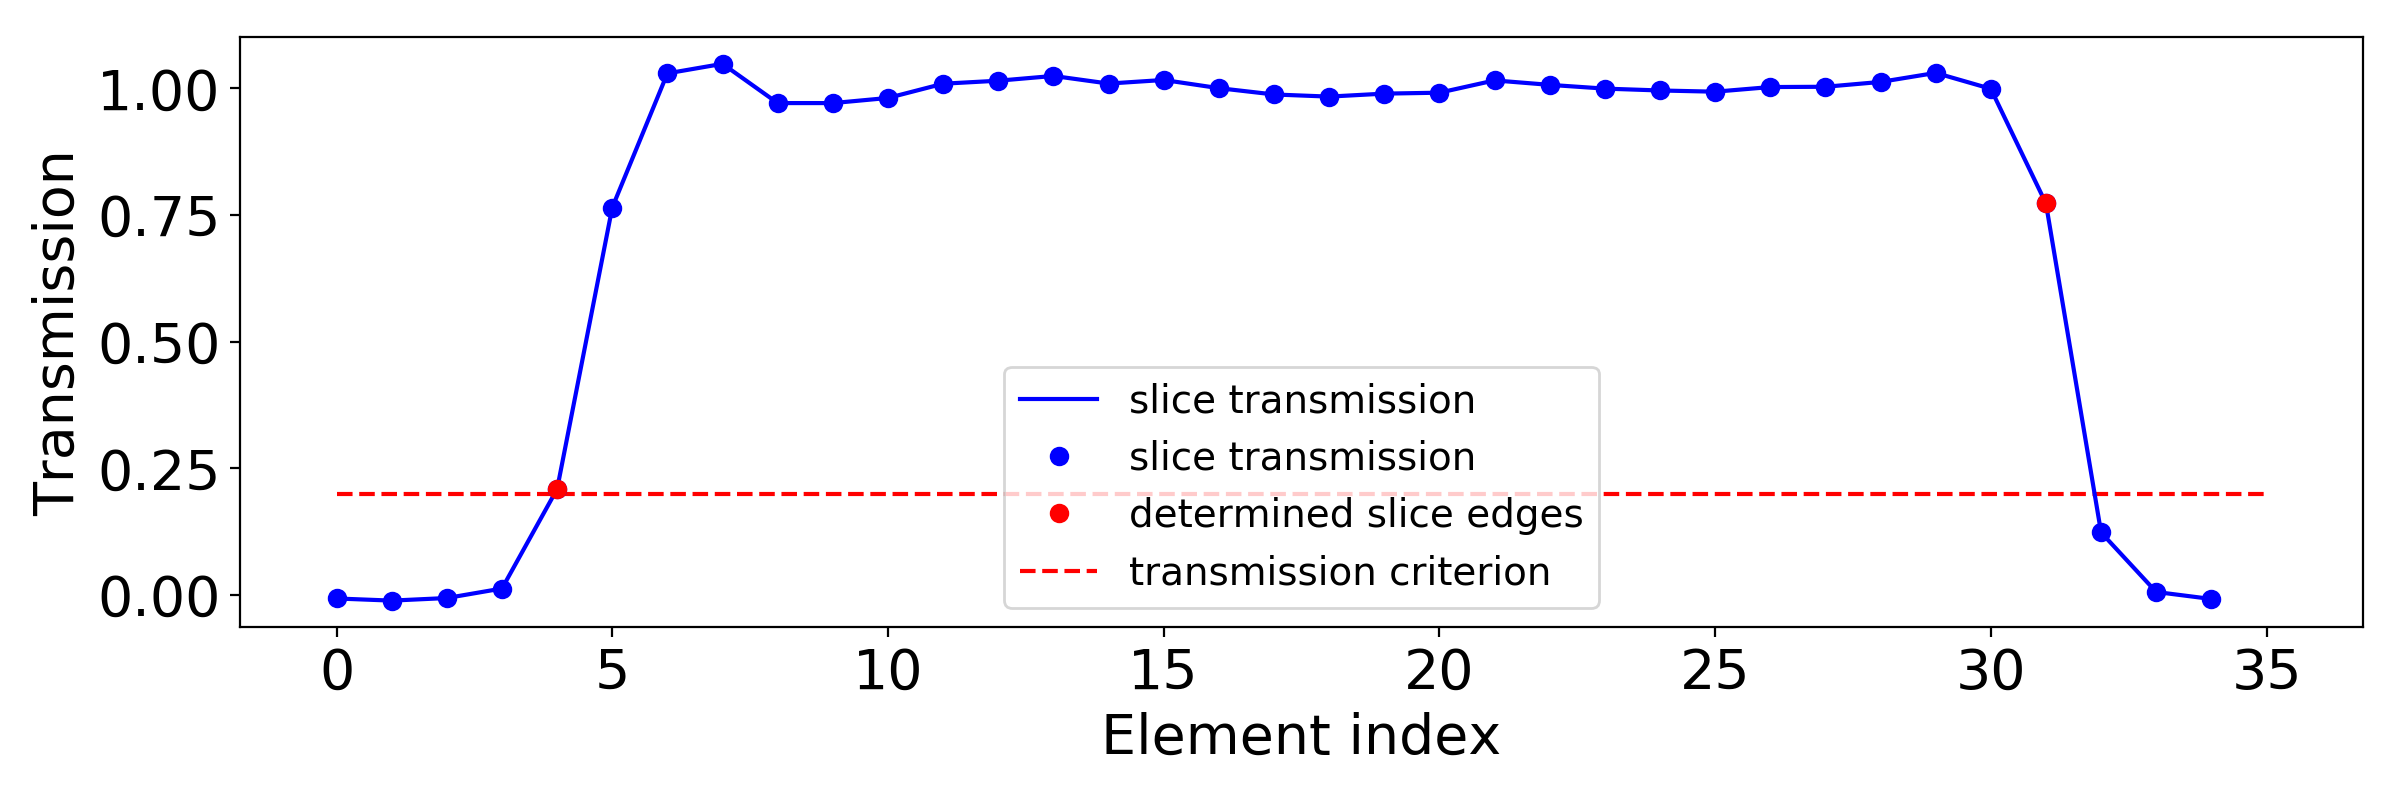

In [37]:
# Test single row, single slice - band 1A
band   = '3A'
row    = 1
islice = sliceid3[0]
margin = 7 # pix
flag   = 0

signal = pd.DataFrame(sci_signal[band])
interp_signal = signal.interpolate(method='nearest').as_matrix()

signal_error = pd.DataFrame(sci_signal_error[band])
interp_signal_error = signal_error.interpolate(method='nearest').as_matrix()

lower = np.where(sliceMap_0percent[band][row,:] == islice)[0][0]
upper = np.where(sliceMap_0percent[band][row,:] == islice)[0][-1]+2

xdata = np.arange(1032)[lower+margin:upper-margin]
ydata = interp_signal[row,lower+margin:upper-margin]
sigma = interp_signal_error[row,lower+margin:upper-margin]

n_poly   = 1
residual_change = 100.
residual_changes = [residual_change]
stop_criterion = 5.
counter = 0
while residual_change > stop_criterion:
    counter += 1
    popt_1     = np.polyfit(xdata,ydata,n_poly,w=1/sigma)
    poly_1     = np.poly1d(popt_1)
    residual_1 = (ydata-poly_1(xdata))**2

    popt_2     = np.polyfit(xdata,ydata,n_poly+1,w=1/sigma)
    poly_2     = np.poly1d(popt_2)
    residual_2 = (ydata-poly_2(xdata))**2
    
    residual_change = np.abs((residual_2.sum()-residual_1.sum())/residual_1.sum())*100.
    residual_changes.append(residual_change)
    print 'Percent residual change {}%'.format(round(residual_change,2))
    
    n_poly+= 1
    
    if residual_changes[counter]>residual_changes[counter-1]:
        print 'Stopping. Residuals are getting larger.'
        print 'Percent residual change {}%'.format(round(residual_changes[counter-1],2))
        flag = 1
        break
    
    if n_poly == 5:
        # stop while loop
        print 'Stopping. Polynnomial order too high.'
        break
    
    if residual_change<=stop_criterion:
        print 'Stopping. {} percent criterion met.'.format(stop_criterion)

if n_poly == 2:
    # first iteration gives good enough fit
    n_polynomial   = 1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1
else:
    # n+1 iteration gives best fit
    n_polynomial   = n_poly-1
    popt     = popt_2
    poly     = poly_2
    residual = residual_2
if flag == 1:
    n_polynomial   = n_poly-1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1

plt.figure(figsize=(12,4))
plt.plot(np.arange(1032)[lower:upper],interp_signal[row,lower:upper],label='slice data')
plt.plot(xdata,ydata,label='in-slice data')
# plt.plot(np.arange(len(np.arange(1032)[512:])),poly(np.arange(len(np.arange(1032)[512:]))),label='polyfit n={}'.format(n_poly))
plt.xlim(lower-margin,upper+margin)
plt.ylim(0.)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(xdata,ydata,label='in-slice data')
plt.plot(np.arange(len(np.arange(1032))),poly(np.arange(len(np.arange(1032)))),label='polyfit n={}'.format(n_polynomial))
plt.xlim(lower,upper)
plt.ylim(0.9*np.min(ydata[~np.isnan(ydata)]),1.1*np.max(ydata[~np.isnan(ydata)]))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] ))
plt.ylim(-0.1,1.1)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Transmission')
plt.tight_layout()

transmission = interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] )

min_idx = np.where(transmission>transm_criterion)[0][0]
if transmission[min_idx] >0.9:
    max_idx = np.where(transmission>transm_criterion)[0][-1]
else:
    max_idx = np.where(transmission>transmission[min_idx])[0][-1]

plt.figure(figsize=(12,4))
plt.plot(transmission,'b',label='slice transmission')
plt.plot(transmission,'bo',label='slice transmission')
plt.plot(min_idx,transmission[min_idx],'ro',label='determined slice edges')
plt.plot(max_idx,transmission[max_idx],'ro')
plt.hlines(transm_criterion,0,len(transmission),'r',linestyle='dashed',label='transmission criterion')
plt.xlabel('Element index')
plt.ylabel('Transmission')
plt.legend(loc='lower center')
plt.tight_layout()

Finally we test the established procedure on band 4C (with a transmission criterion of 90%).

Percent residual change 19.82%
Percent residual change 41.71%
Stopping. Residuals are getting larger.
Percent residual change 19.82%


<IPython.core.display.Javascript object>


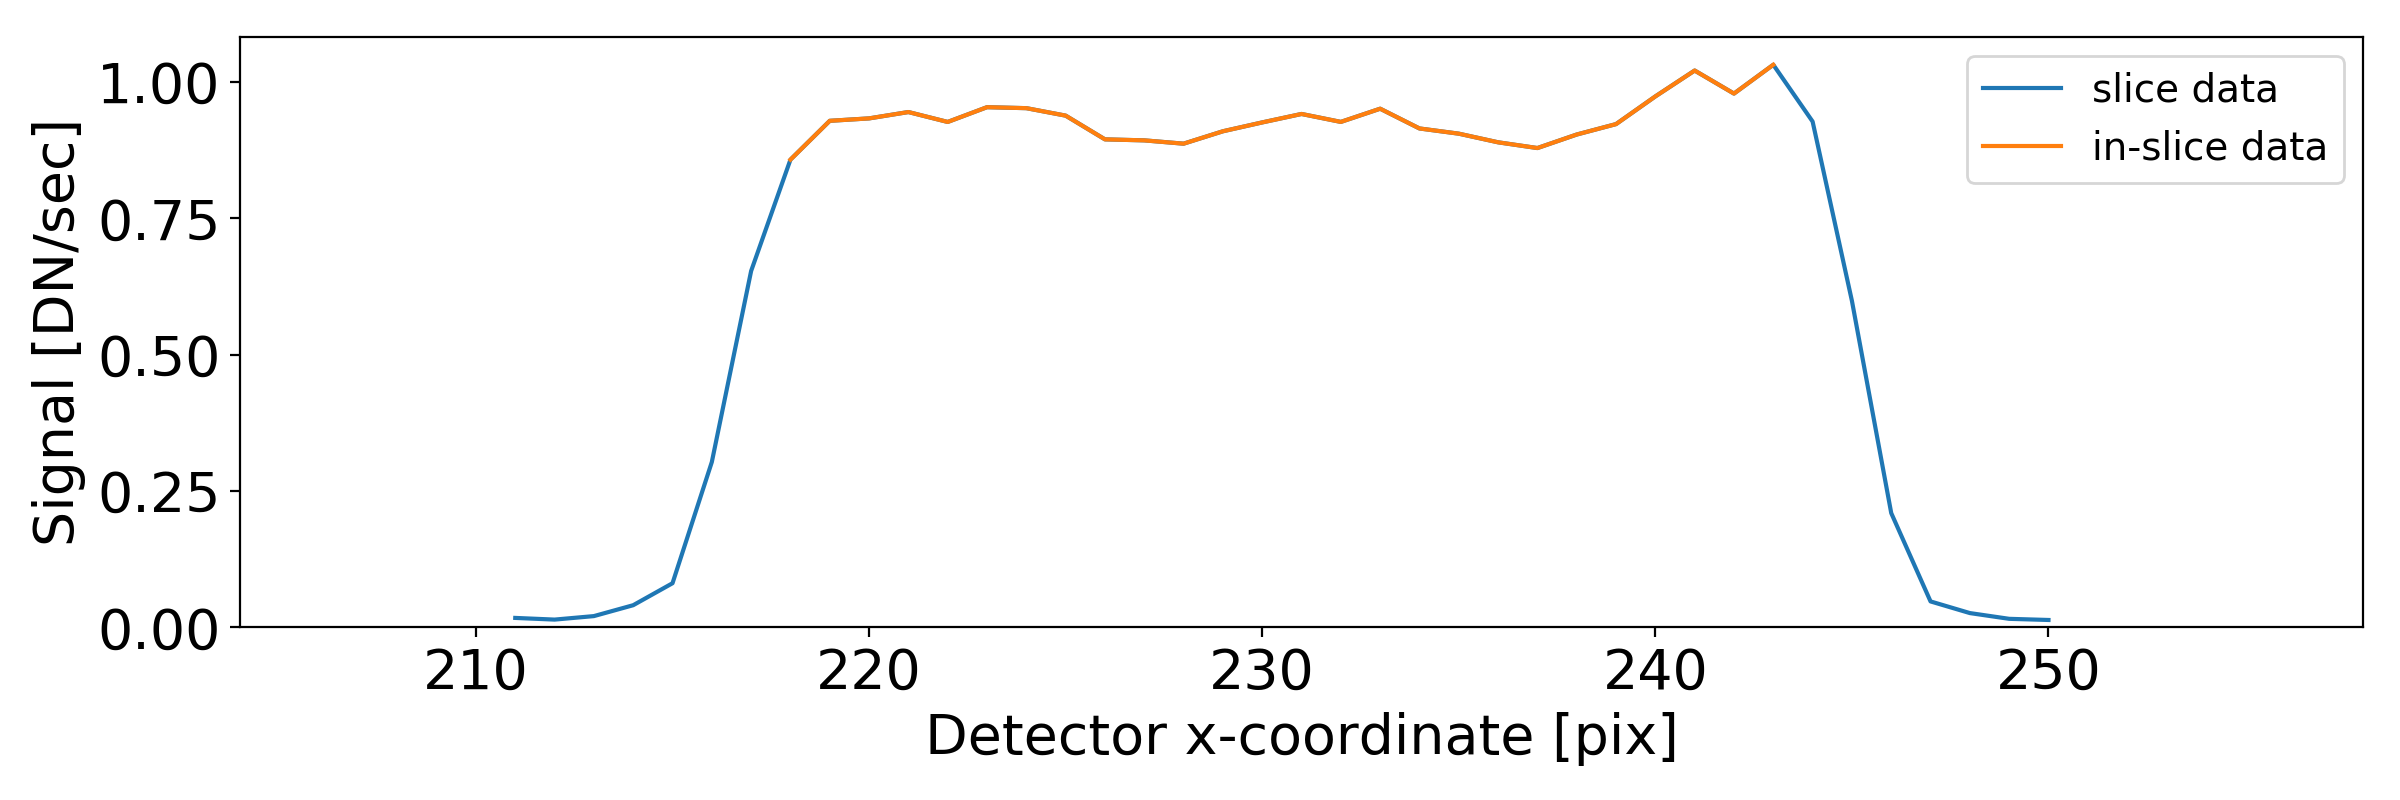

<IPython.core.display.Javascript object>


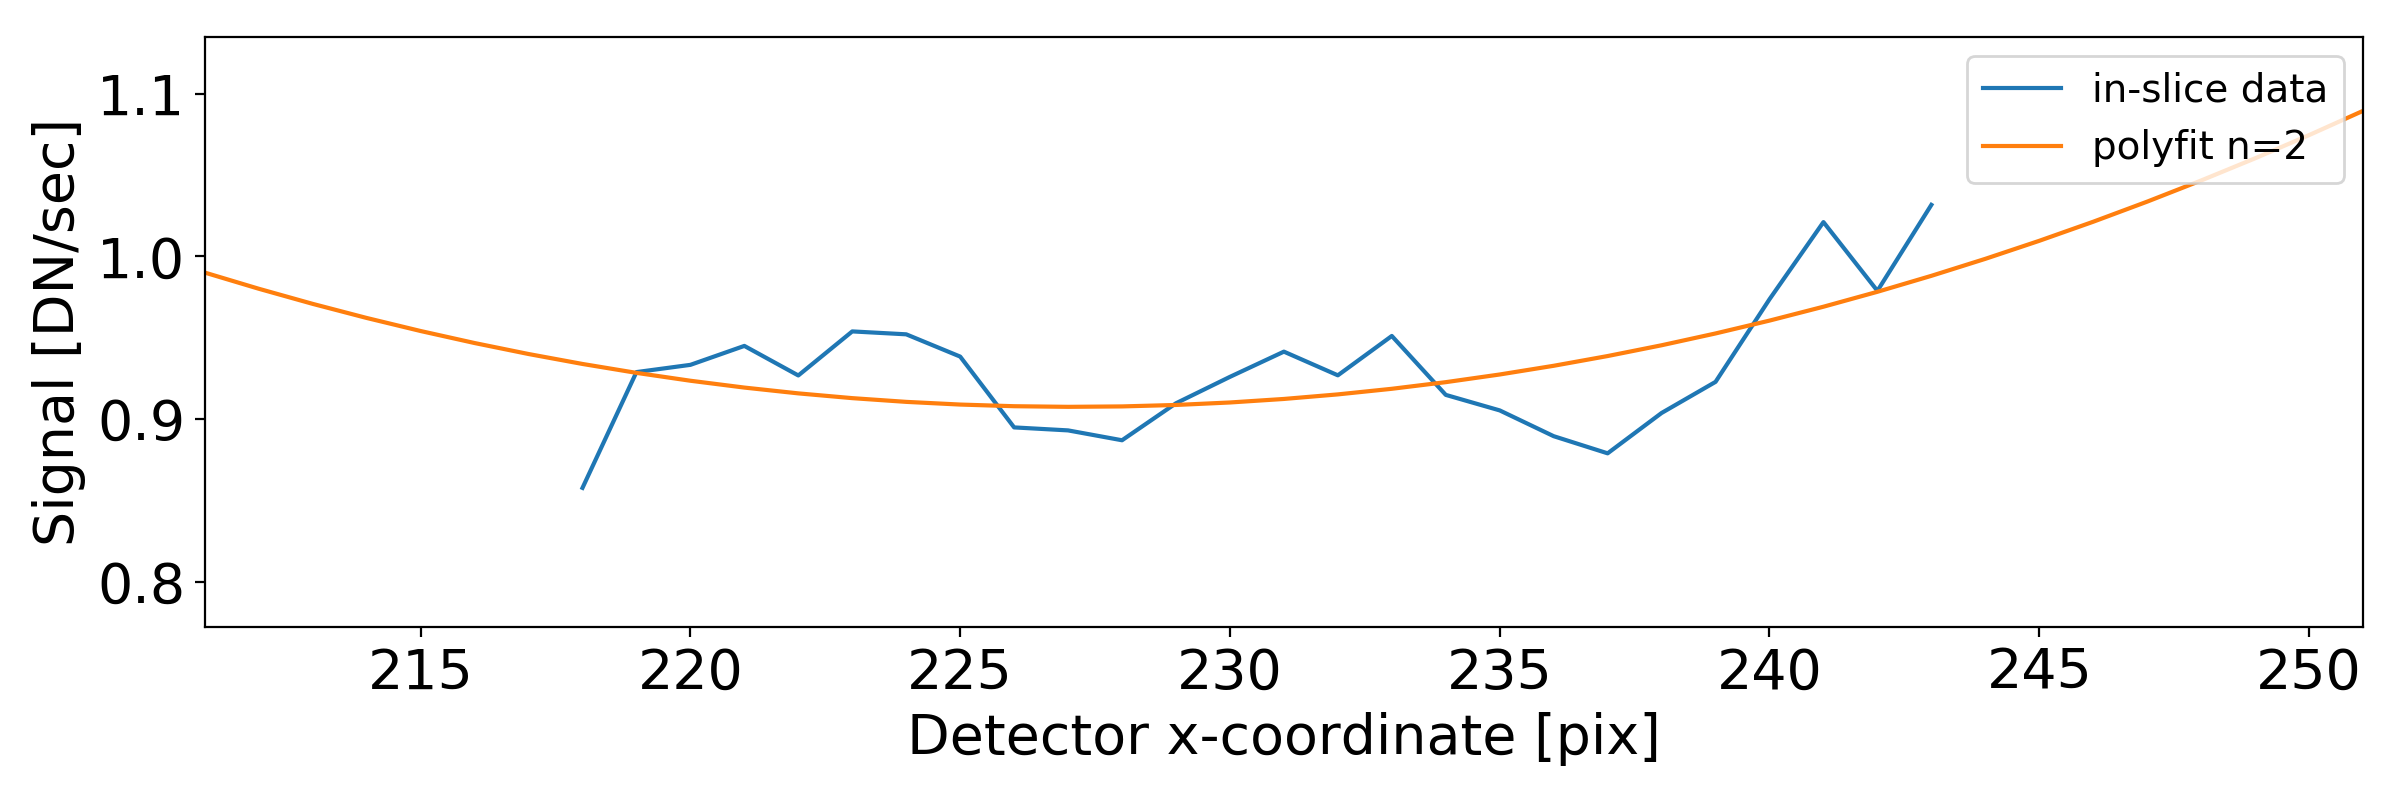

<IPython.core.display.Javascript object>


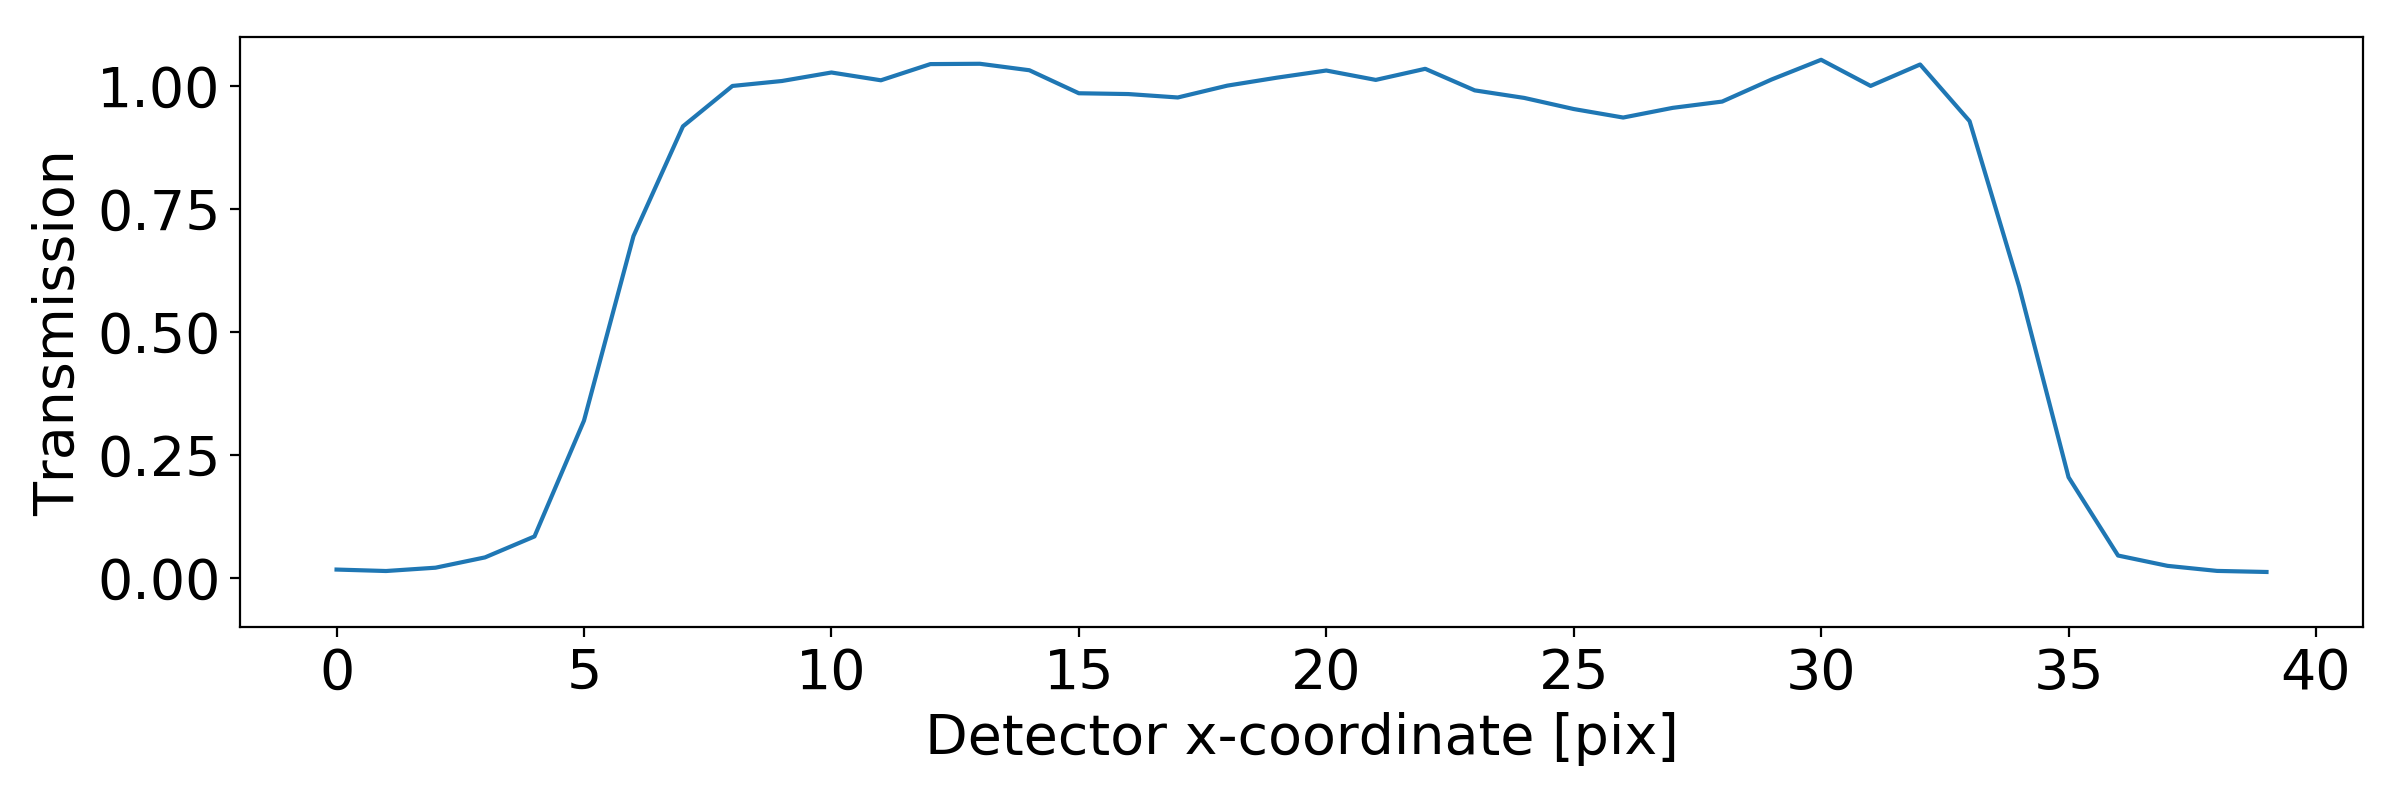

<IPython.core.display.Javascript object>


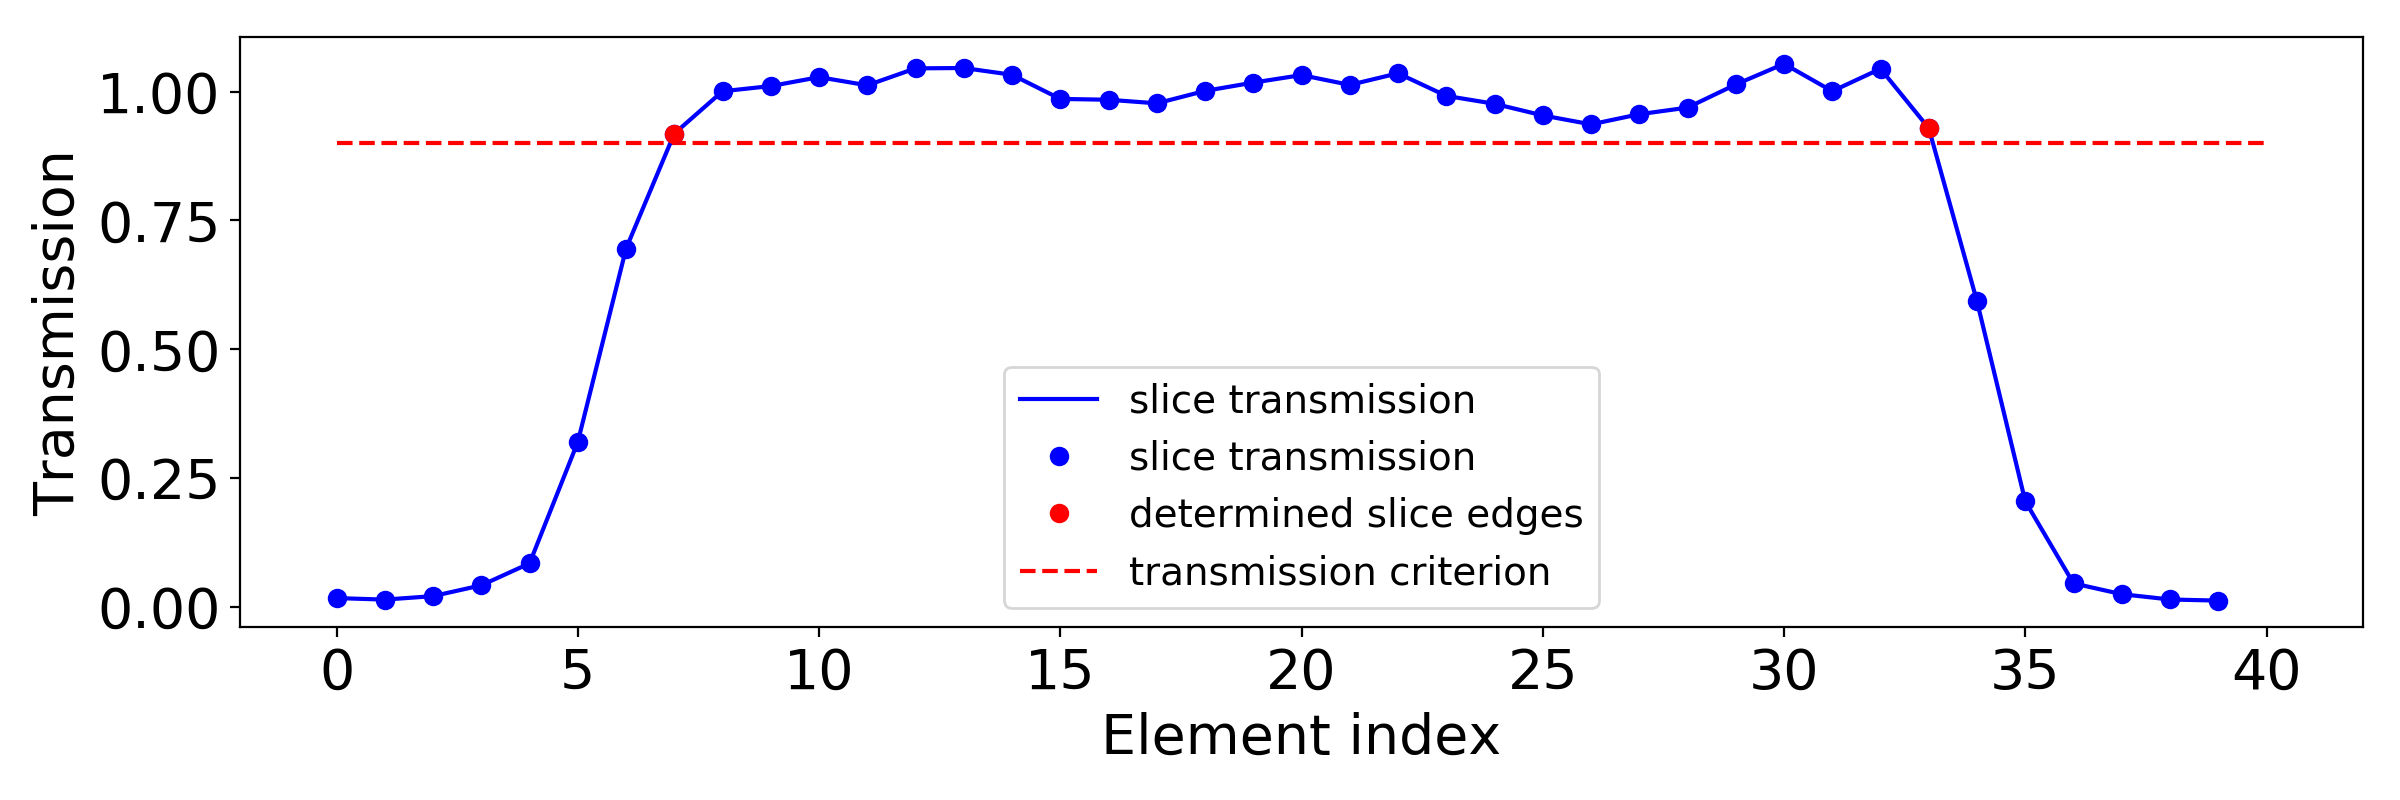

In [157]:
# Test single row, single slice - band 1A
band   = '4C'
row    = 500
islice = 404
margin = 7 # pix
flag   = 0

signal = pd.DataFrame(sci_signal[band])
interp_signal = signal.interpolate(method='nearest',axis=1).as_matrix()

signal_error = pd.DataFrame(sci_signal_error[band])
interp_signal_error = signal_error.interpolate(method='nearest',axis=1).as_matrix()

lower = np.where(sliceMap_0percent[band][row,:] == islice)[0][0]
upper = np.where(sliceMap_0percent[band][row,:] == islice)[0][-1]+2

xdata = np.arange(1032)[lower+margin:upper-margin]
ydata = interp_signal[row,lower+margin:upper-margin]
sigma = interp_signal_error[row,lower+margin:upper-margin]

n_poly   = 1
residual_change = 100.
residual_changes = [residual_change]
stop_criterion = 5.
counter = 0
while residual_change > stop_criterion:
    counter += 1
    popt_1     = np.polyfit(xdata,ydata,n_poly,w=1/sigma)
    poly_1     = np.poly1d(popt_1)
    residual_1 = (ydata-poly_1(xdata))**2

    popt_2     = np.polyfit(xdata,ydata,n_poly+1,w=1/sigma)
    poly_2     = np.poly1d(popt_2)
    residual_2 = (ydata-poly_2(xdata))**2
    
    residual_change = np.abs((residual_2.sum()-residual_1.sum())/residual_1.sum())*100.
    residual_changes.append(residual_change)
    print 'Percent residual change {}%'.format(round(residual_change,2))
    
    n_poly+= 1
    
    if residual_changes[counter]>residual_changes[counter-1]:
        print 'Stopping. Residuals are getting larger.'
        print 'Percent residual change {}%'.format(round(residual_changes[counter-1],2))
        flag = 1
        break
    
    if n_poly == 5:
        # stop while loop
        print 'Stopping. Polynnomial order too high.'
        break
    
    if residual_change<=stop_criterion:
        print 'Stopping. {} percent criterion met.'.format(stop_criterion)

if n_poly == 2:
    # first iteration gives good enough fit
    n_polynomial   = 1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1
else:
    # n+1 iteration gives best fit
    n_polynomial   = n_poly-1
    popt     = popt_2
    poly     = poly_2
    residual = residual_2
if flag == 1:
    n_polynomial   = n_poly-1
    popt     = popt_1
    poly     = poly_1
    residual = residual_1

plt.figure(figsize=(12,4))
plt.plot(np.arange(1032)[lower:upper],interp_signal[row,lower:upper],label='slice data')
plt.plot(xdata,ydata,label='in-slice data')
# plt.plot(np.arange(len(np.arange(1032)[512:])),poly(np.arange(len(np.arange(1032)[512:]))),label='polyfit n={}'.format(n_poly))
plt.xlim(lower-margin,upper+margin)
plt.ylim(0.)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(xdata,ydata,label='in-slice data')
plt.plot(np.arange(len(np.arange(1032))),poly(np.arange(len(np.arange(1032)))),label='polyfit n={}'.format(n_polynomial))
plt.xlim(lower,upper)
plt.ylim(0.9*np.min(ydata[~np.isnan(ydata)]),1.1*np.max(ydata[~np.isnan(ydata)]))
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] ))
plt.ylim(-0.1,1.1)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Transmission')
plt.tight_layout()

transmission = interp_signal[row,lower:upper]/poly(np.arange(1032)[lower:upper] )

min_idx = np.where(transmission>transm_criterion)[0][0]
# if transmission[min_idx] >0.9:
max_idx = np.where(transmission>transm_criterion)[0][-1]
# else:
#     max_idx = np.where(transmission>transmission[min_idx])[0][-1]

plt.figure(figsize=(12,4))
plt.plot(transmission,'b',label='slice transmission')
plt.plot(transmission,'bo',label='slice transmission')
plt.plot(min_idx,transmission[min_idx],'ro',label='determined slice edges')
plt.plot(max_idx,transmission[max_idx],'ro')
plt.hlines(transm_criterion,0,len(transmission),'r',linestyle='dashed',label='transmission criterion')
plt.xlabel('Element index')
plt.ylabel('Transmission')
plt.legend(loc='lower center')
plt.tight_layout()

In [ ]:
# Test all slices, all rows - band 1A
band   = '4C'
margin = 7 # pix
transm_criterion = 0.9
new_sliceMap = np.zeros((1024,1032))
transm_img = np.zeros((1024,1032))

signal = pd.DataFrame(sci_signal[band])
interp_signal = signal.interpolate(method='nearest',axis=1).as_matrix()

signal_error = pd.DataFrame(sci_signal_error[band])
interp_signal_error = signal_error.interpolate(method='nearest',axis=1).as_matrix()

for islice in sliceid4:
    print 'Slice {}'.format(islice)
    for row in range(1,1023):
        lower = np.where(sliceMap_0percent[band][row,:] == islice)[0][0]
        upper = np.where(sliceMap_0percent[band][row,:] == islice)[0][-1]+2

        xdata = np.arange(1032)[lower+margin:upper-margin]
        ydata = interp_signal[row,lower+margin:upper-margin]
        sigma = interp_signal_error[row,lower+margin:upper-margin]

        n_poly   = 1
        residual_change = 100.
        residual_changes = [residual_change]
        stop_criterion = 5.
        counter = 0
        flag    = 0
        while residual_change > stop_criterion:
            counter += 1
            popt_1     = np.polyfit(xdata,ydata,n_poly,w=1/sigma)
            poly_1     = np.poly1d(popt_1)
            residual_1 = (ydata-poly_1(xdata))**2

            popt_2     = np.polyfit(xdata,ydata,n_poly+1,w=1/sigma)
            poly_2     = np.poly1d(popt_2)
            residual_2 = (ydata-poly_2(xdata))**2

            residual_change = np.abs((residual_2.sum()-residual_1.sum())/residual_1.sum())*100.
            residual_changes.append(residual_change)

            n_poly+= 1

            if residual_changes[counter]>residual_changes[counter-1]:
                flag = 1
                break

            if n_poly == 5:
                break

        if n_poly == 2:
            # first iteration gives good enough fit
            n_polynomial   = 1
            popt     = popt_1
            poly     = poly_1
            residual = residual_1
        else:
            # n+1 iteration gives best fit
            n_polynomial   = n_poly-1
            popt     = popt_2
            poly     = poly_2
            residual = residual_2
        if flag == 1:
            n_polynomial   = n_poly-1
            popt     = popt_1
            poly     = poly_1
            residual = residual_1

        transmission = sci_signal[band][row,lower:upper]/poly(np.arange(1032)[lower:upper] )
        transm_img[row,lower:upper] = transmission

        min_idx = np.where(transmission>transm_criterion)[0][0]
        max_idx = np.where(transmission>transm_criterion)[0][-1]

        new_sliceMap[row,lower+min_idx+1:lower+max_idx] = islice
new_sliceMap[0,:] = new_sliceMap[1,:]
new_sliceMap[1023,:] = new_sliceMap[1022,:]

In [ ]:
new_sliceMap_poly = np.zeros((1024,1032))
edge_pixels_left,edge_pixels_right = {},{}
for islice in sliceid4:
    edge_pixels_left[str(islice)],edge_pixels_right[str(islice)] = np.zeros(1024),np.zeros(1024)
    for row in range(1024):
        edge_pixels_left[str(islice)][row]  = np.where(new_sliceMap[row,:] == islice)[0][0]
        edge_pixels_right[str(islice)][row] = np.where(new_sliceMap[row,:] == islice)[0][-1]
    
    # shifts of more than two pixels are rejected
    for row in range(1,1024):
        if (np.abs(edge_pixels_left[str(islice)][row]-edge_pixels_left[str(islice)][row-1]) ==2):
            edge_pixels_left[str(islice)][row-1] = np.nan
            
        if (np.abs(edge_pixels_right[str(islice)][row]-edge_pixels_right[str(islice)][row-1]) ==2):
            edge_pixels_right[str(islice)][row-1] = np.nan
        
    sel_left  = ~np.isnan(edge_pixels_left[str(islice)])
    popt_left = np.polyfit(np.arange(1024)[sel_left],edge_pixels_left[str(islice)][sel_left],4)
    poly_left = np.poly1d(popt_left)
    
    sel_right  = ~np.isnan(edge_pixels_right[str(islice)])
    popt_right = np.polyfit(np.arange(1024)[sel_right],edge_pixels_right[str(islice)][sel_right],4)
    poly_right = np.poly1d(popt_right)
    
    for row in range(1024):
        assert np.around(poly_left(np.arange(1024))[row])<=np.around(poly_right(np.arange(1024))[row])+2, 'Something went wrong in the polynomial fitting'
        new_sliceMap_poly[row,np.around(poly_left(np.arange(1024))[row]):np.around(poly_right(np.arange(1024))[row])+2] = islice

<IPython.core.display.Javascript object>


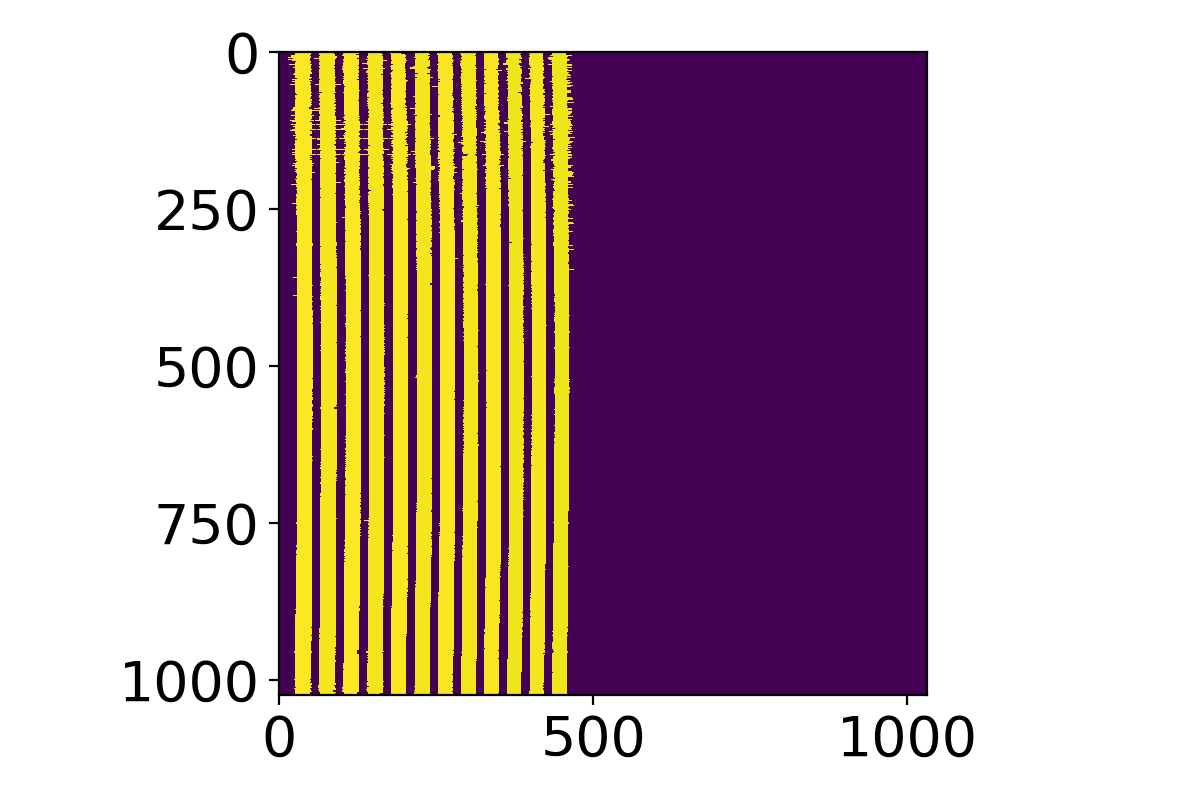

<IPython.core.display.Javascript object>


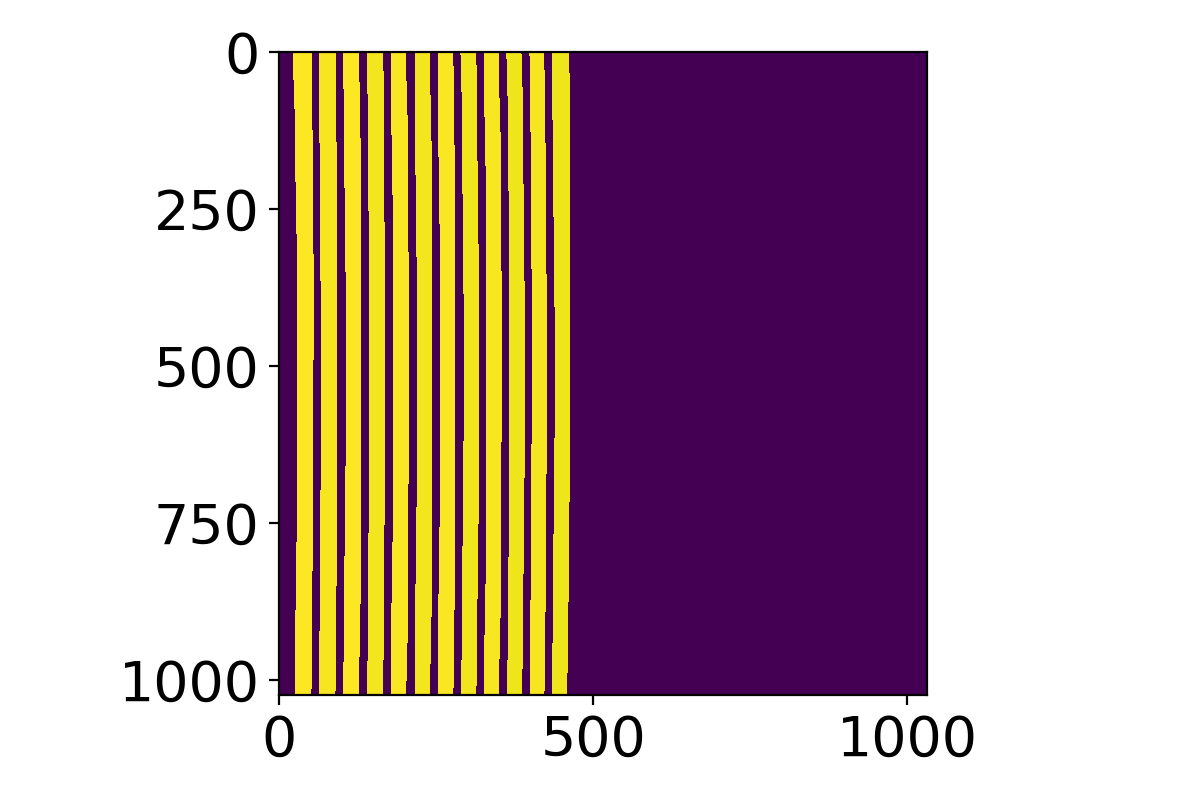

<IPython.core.display.Javascript object>


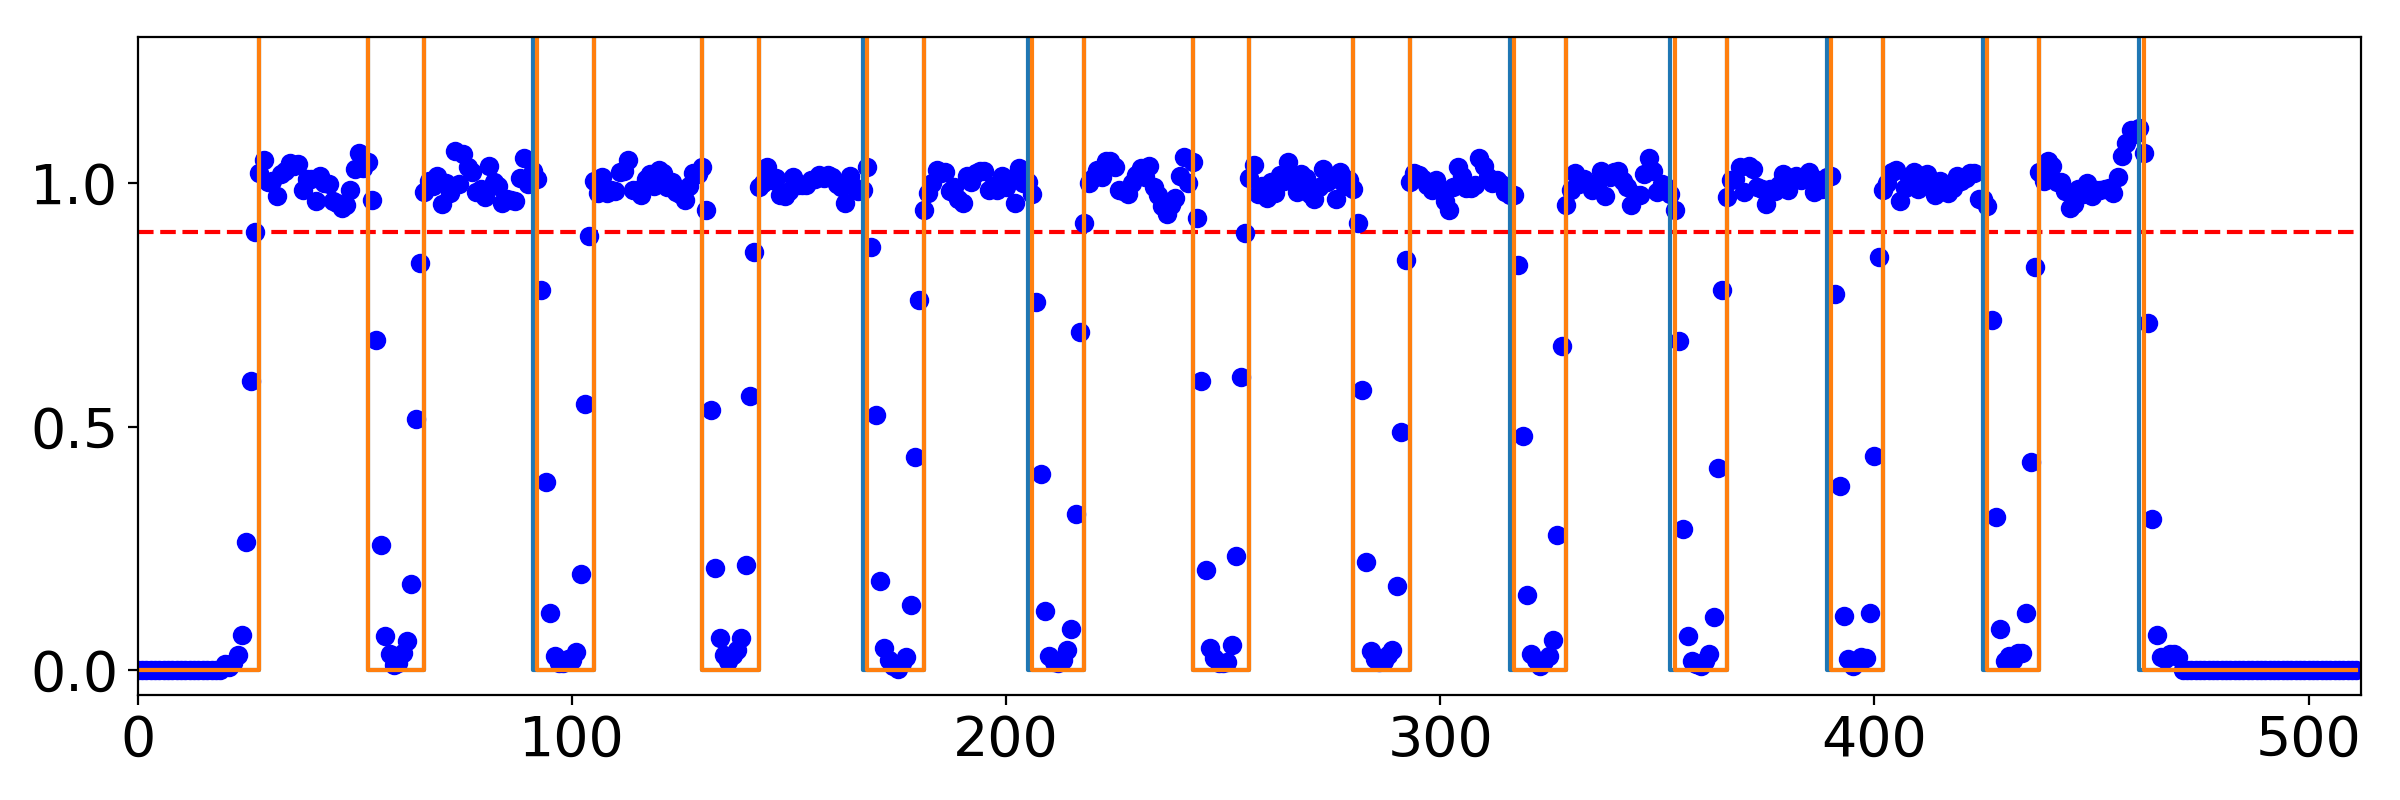

In [158]:
plt.figure(figsize=(6,4))
plt.imshow(new_sliceMap)
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.imshow(new_sliceMap_poly)
plt.tight_layout()

row = 500
if band[0] in ['1','4']:
    plt.figure(figsize=(12,4))
    plt.plot(np.arange(len(transm_img[row,:512])),transm_img[row,:512],'bo')
    plt.step(np.arange(len(new_sliceMap[row,:512])),new_sliceMap[row,:512])
    plt.step(np.arange(len(new_sliceMap_poly[row,:512])),new_sliceMap_poly[row,:512])
    plt.hlines(transm_criterion,0,512,'r',linestyle='dashed')
    plt.ylim(-0.05,1.3)
    plt.xlim(0,512)
    plt.tight_layout()
elif band[0] in ['2','3']:
    plt.figure(figsize=(12,4))
    plt.plot(np.arange(len(transm_img[row,512:])),transm_img[row,512:],'bo')
    plt.step(np.arange(len(new_sliceMap[row,512:])),new_sliceMap[row,512:])
    plt.step(np.arange(len(new_sliceMap_poly[row,512:])),new_sliceMap_poly[row,512:])
    plt.hlines(transm_criterion,0,512,'r',linestyle='dashed')
    plt.ylim(-0.05,1.3)
    plt.xlim(0,512)
    plt.tight_layout()